In [1]:
pip install git+https://gitlab.com/IvanSeleznov/ofsca.git@v1.2

  Cloning https://gitlab.com/IvanSeleznov/ofsca.git (to revision v1.2) to /tmp/pip-req-build-le3p3y2w
  Running command git clone --filter=blob:none --quiet https://gitlab.com/IvanSeleznov/ofsca.git /tmp/pip-req-build-le3p3y2w
  Running command git checkout -b v1.2 --track origin/v1.2
  Switched to a new branch 'v1.2'
  Branch 'v1.2' set up to track remote branch 'v1.2' from 'origin'.
  Resolved https://gitlab.com/IvanSeleznov/ofsca.git to commit 176dd3c5eaf98cef66cbd6135361a47ee9928163
  Preparing metadata (setup.py) ... done
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you

In [2]:
# import ofsca.examples.numerical_example as ofsca_numerical_example
# import matplotlib.pyplot as plt

In [3]:
# fig = ofsca_numerical_example.example_numerical()
# plt.tight_layout()
# plt.show()

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from os import walk
import numpy as np
import matplotlib.animation as animation
import pandas.io.json as pd_json
import json
import statistics as stats
from scipy.stats import mannwhitneyu
from scipy.spatial import distance as dist
from scipy.signal import find_peaks
from ofsca import ofsca

In [5]:
df = pd.read_csv("../preprocessed.csv")
df['BPOGX'] = df['BPOGX'].apply(lambda x: json.loads(x))
df['BPOGY'] = df['BPOGY'].apply(lambda x: json.loads(x))
df['X_HEAD'] = df['X_HEAD'].apply(lambda x: json.loads(x))
df['Y_HEAD'] = df['Y_HEAD'].apply(lambda x: json.loads(x))
df.head()

,Session_id,BPOGX,BPOGY,X_HEAD,Y_HEAD,Left_closed,Right_closed,Valid_data,Session_desc,Duration_sec,Screen_width,Screen_height,Screen_ratio,Read_score
0,0vDqTTS4iDY6DF5NOp8f,"[-35.0, 0.2, 48.9, 88.0, 126.2, 146.3, 143.1, ...","[140.8, 140.3, 141.0, 140.6, 138.8, 137.2, 126...","[337.6, 337.6, 337.7, 337.7, 337.7, 337.7, 337...","[232.9, 233.2, 233.2, 233.8, 234.2, 234.6, 234...","[True, False, False, False, False, False, Fals...","[True, True, True, True, False, True, False, T...",1.000000,Normal Scan,273.000000,1366,768,1.0,NaN
1,IxFK072TVWPwYlGys7rw,"[30.6, 82.9, 142.8, 184.7, 229.8, 283.6, 307.3...","[158.2, 154.7, 146.6, 132.5, 119.8, 135.6, 160...","[375.6, 375.6, 375.2, 375.0, 374.8, 374.0, 373...","[187.1, 187.1, 186.8, 186.6, 186.4, 185.7, 185...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",1.000000,Normal Read,185.500000,1366,768,1.0,4.0
2,2N0kUSJASI5JIwtMnJ6Z,"[1242.9, 1260.6, 1243.1, 1222.5, 1206.1, 1169....","[319.1, 354.4, 394.2, 420.2, 421.9, 407.6, 386...","[387.3, 387.5, 387.6, 387.8, 387.8, 388.1, 388...","[282.8, 282.4, 282.3, 282.6, 282.9, 282.7, 282...","[True, True, False, False, False, False, False...","[True, True, False, False, False, False, False...",0.999344,Normal Scan,304.766667,1280,720,1.5,NaN
3,eVx48oKwJpOecNEasAHf,"[679.6, 692.7, 698.4, 711.4, 746.1, 843.4, 100...","[110.3, 107.4, 102.8, 109.5, 115.4, 132.1, 88....","[366.1, 366.2, 366.3, 366.2, 366.3, 366.3, 366...","[263.7, 263.5, 263.3, 263.4, 263.3, 263.4, 264...","[False, False, False, False, False, False, Tru...","[False, False, False, False, False, True, True...",0.999872,Normal Read,518.866667,1280,720,1.5,4.0
4,qxdzibb5ytmZyniXGkN2,"[2806.5, 3401.2, 4244.1, 4703.6, 4860.1, 4774....","[1791.8, 1902.1, 2050.6, 2048.4, 2019.7, 1909....","[305.2, 304.6, 304.8, 304.4, 303.5, 303.3, 303...","[118.3, 118.4, 118.6, 120.2, 120.8, 119.7, 119...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",0.950809,Normal Scan,96.000000,1440,900,2.0,NaN


In [6]:
def indices_condition(arr, thr):
    negative_mask = arr < 0
    greater_than_mask = arr > thr
    
    combined_mask = np.logical_or(negative_mask, greater_than_mask)
    indices = np.where(combined_mask)
    
    return indices

def filter_coordinates(row):
    screen_width = row['Screen_width']
    screen_height = row['Screen_height']
    x = np.array(row['BPOGX'])
    y = np.array(row['BPOGY'])
    x_invalid = indices_condition(x, screen_width)
    y_invalid = indices_condition(y, screen_height)
    combined_indices = np.concatenate((x_invalid, y_invalid), axis=1)
    x_valid = np.delete(x, combined_indices)
    y_valid = np.delete(y, combined_indices)
    valid_ratio = len(x_valid) / len(x)
    valid_dur = row['Duration_sec'] * valid_ratio
    return x_valid, y_valid, valid_dur

# Apply the function to each row
df['Filtered_BPOGX'], df['Filtered_BPOGY'], df['Valid_duration'] = zip(*df.apply(filter_coordinates, axis=1))
df.head()

,Session_id,BPOGX,BPOGY,X_HEAD,Y_HEAD,Left_closed,Right_closed,Valid_data,Session_desc,Duration_sec,Screen_width,Screen_height,Screen_ratio,Read_score,Filtered_BPOGX,Filtered_BPOGY,Valid_duration
0,0vDqTTS4iDY6DF5NOp8f,"[-35.0, 0.2, 48.9, 88.0, 126.2, 146.3, 143.1, ...","[140.8, 140.3, 141.0, 140.6, 138.8, 137.2, 126...","[337.6, 337.6, 337.7, 337.7, 337.7, 337.7, 337...","[232.9, 233.2, 233.2, 233.8, 234.2, 234.6, 234...","[True, False, False, False, False, False, Fals...","[True, True, True, True, False, True, False, T...",1.000000,Normal Scan,273.000000,1366,768,1.0,NaN,"[0.2, 48.9, 88.0, 126.2, 146.3, 143.1, 134.2, ...","[140.3, 141.0, 140.6, 138.8, 137.2, 126.7, 124...",214.200000
1,IxFK072TVWPwYlGys7rw,"[30.6, 82.9, 142.8, 184.7, 229.8, 283.6, 307.3...","[158.2, 154.7, 146.6, 132.5, 119.8, 135.6, 160...","[375.6, 375.6, 375.2, 375.0, 374.8, 374.0, 373...","[187.1, 187.1, 186.8, 186.6, 186.4, 185.7, 185...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",1.000000,Normal Read,185.500000,1366,768,1.0,4.0,"[30.6, 82.9, 142.8, 184.7, 229.8, 283.6, 307.3...","[158.2, 154.7, 146.6, 132.5, 119.8, 135.6, 160...",173.933333
2,2N0kUSJASI5JIwtMnJ6Z,"[1242.9, 1260.6, 1243.1, 1222.5, 1206.1, 1169....","[319.1, 354.4, 394.2, 420.2, 421.9, 407.6, 386...","[387.3, 387.5, 387.6, 387.8, 387.8, 388.1, 388...","[282.8, 282.4, 282.3, 282.6, 282.9, 282.7, 282...","[True, True, False, False, False, False, False...","[True, True, False, False, False, False, False...",0.999344,Normal Scan,304.766667,1280,720,1.5,NaN,"[1242.9, 1260.6, 1243.1, 1222.5, 1206.1, 1169....","[319.1, 354.4, 394.2, 420.2, 421.9, 407.6, 386...",269.133333
3,eVx48oKwJpOecNEasAHf,"[679.6, 692.7, 698.4, 711.4, 746.1, 843.4, 100...","[110.3, 107.4, 102.8, 109.5, 115.4, 132.1, 88....","[366.1, 366.2, 366.3, 366.2, 366.3, 366.3, 366...","[263.7, 263.5, 263.3, 263.4, 263.3, 263.4, 264...","[False, False, False, False, False, False, Tru...","[False, False, False, False, False, True, True...",0.999872,Normal Read,518.866667,1280,720,1.5,4.0,"[679.6, 692.7, 698.4, 711.4, 746.1, 843.4, 100...","[110.3, 107.4, 102.8, 109.5, 115.4, 132.1, 88....",439.200000
4,qxdzibb5ytmZyniXGkN2,"[2806.5, 3401.2, 4244.1, 4703.6, 4860.1, 4774....","[1791.8, 1902.1, 2050.6, 2048.4, 2019.7, 1909....","[305.2, 304.6, 304.8, 304.4, 303.5, 303.3, 303...","[118.3, 118.4, 118.6, 120.2, 120.8, 119.7, 119...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",0.950809,Normal Scan,96.000000,1440,900,2.0,NaN,"[1435.8, 1189.8, 989.6, 787.2, 670.0, 522.0, 3...","[551.6, 492.7, 463.5, 444.1, 432.9, 466.9, 492...",47.533333


# Spectral Analysis

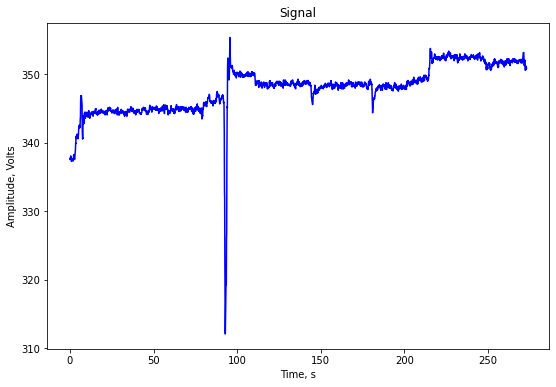

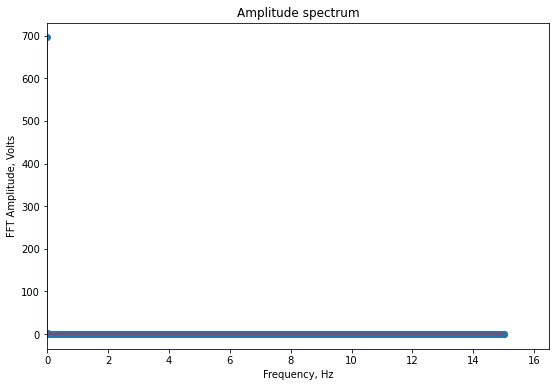

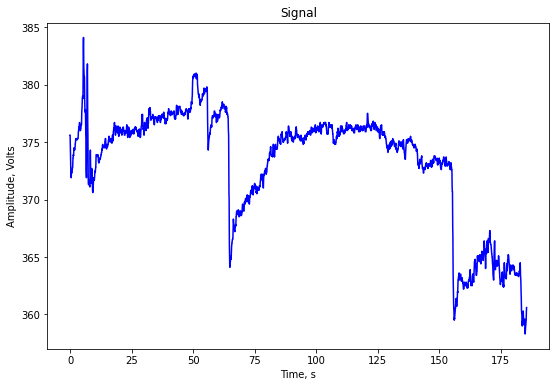

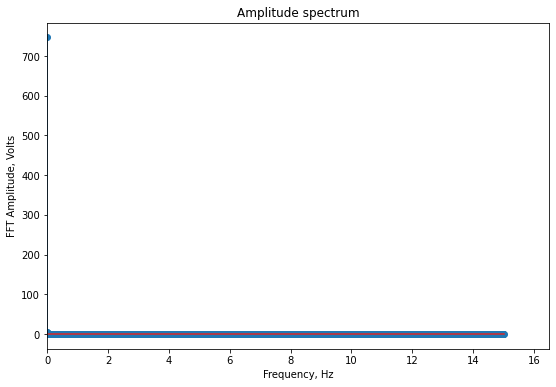

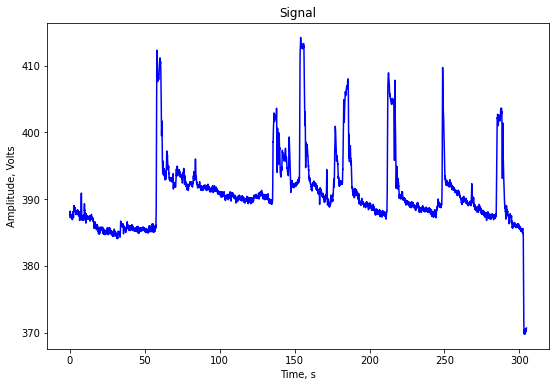

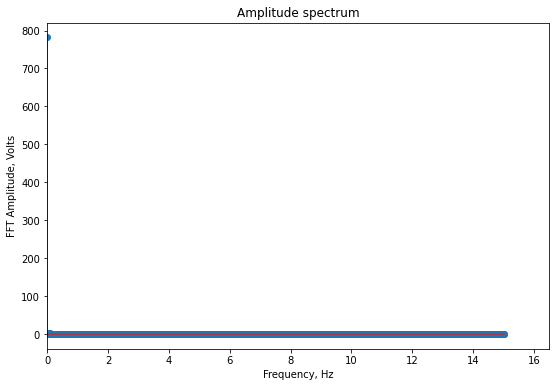

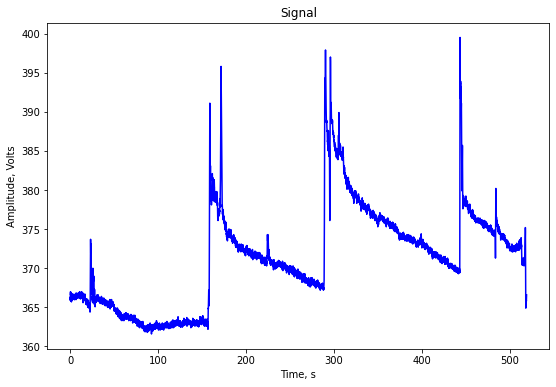

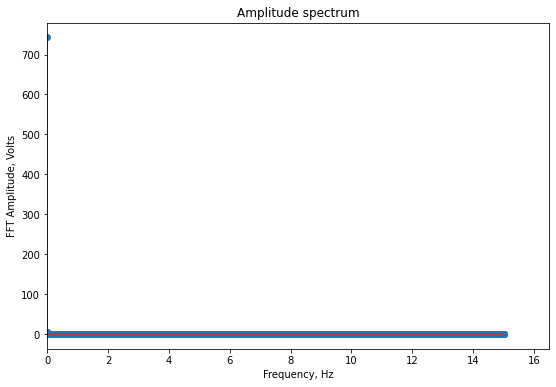

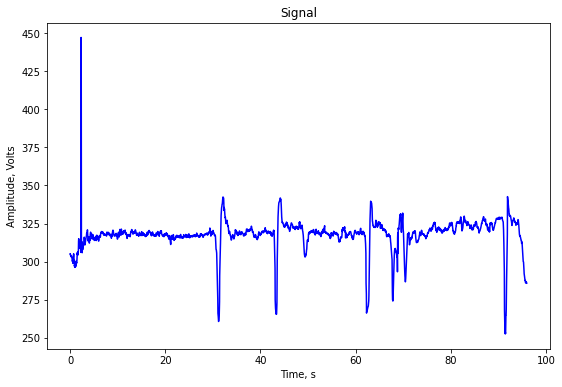

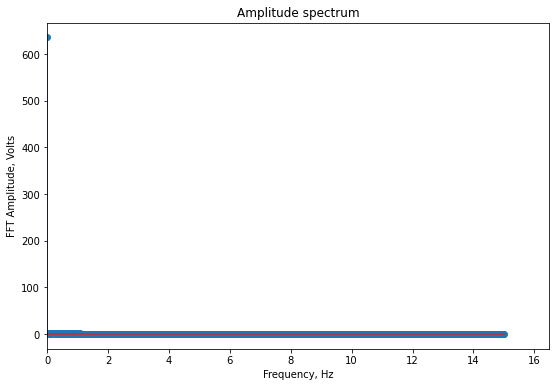

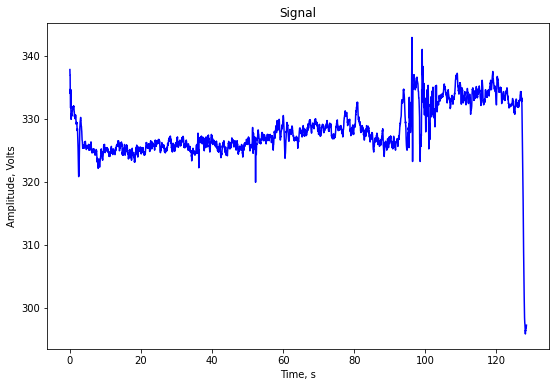

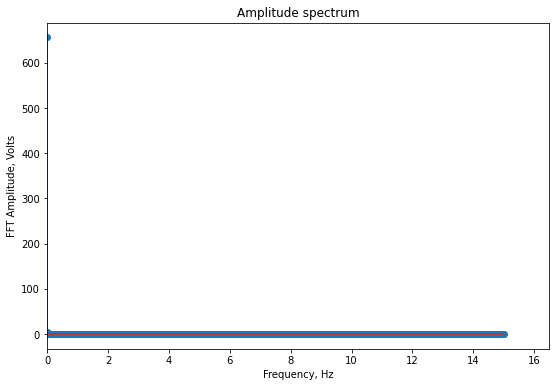

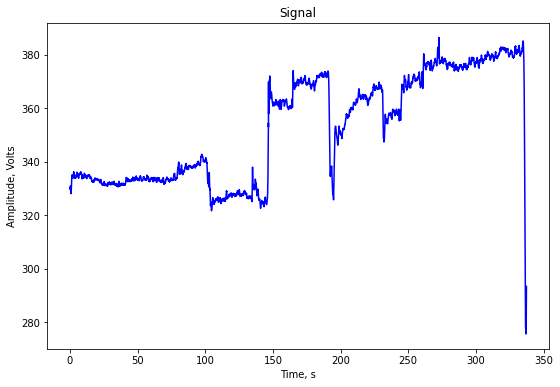

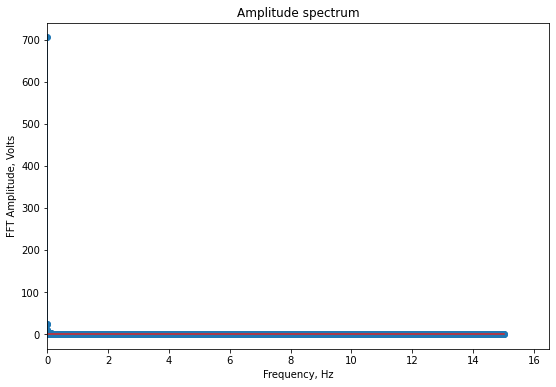

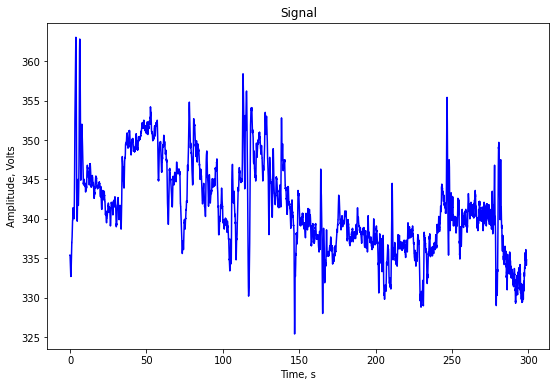

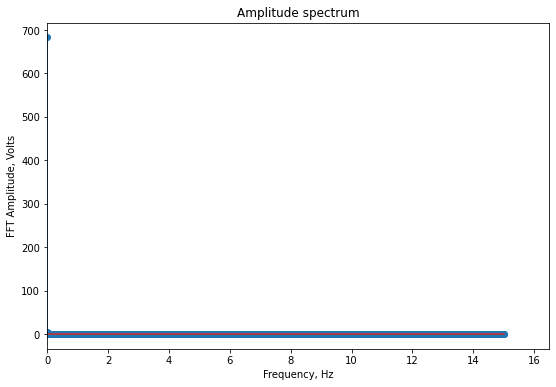

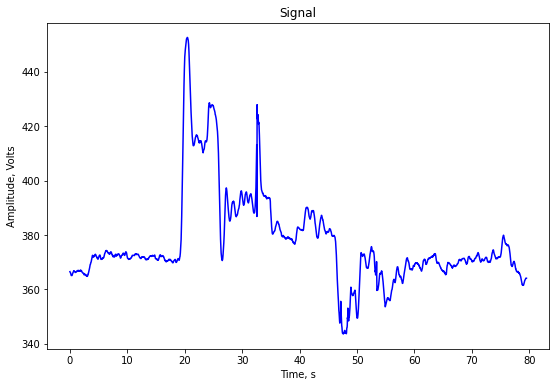

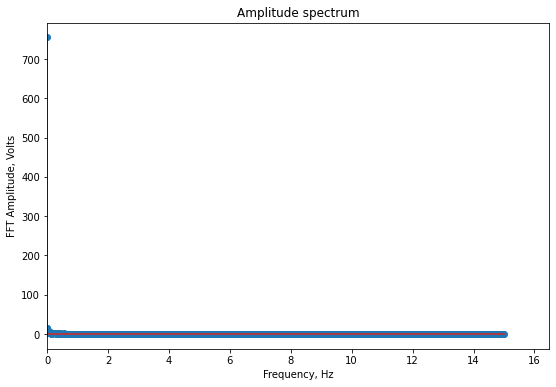

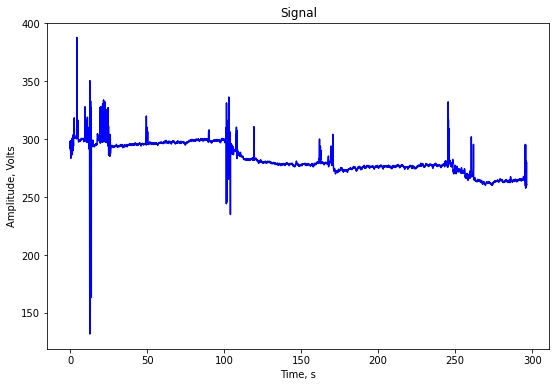

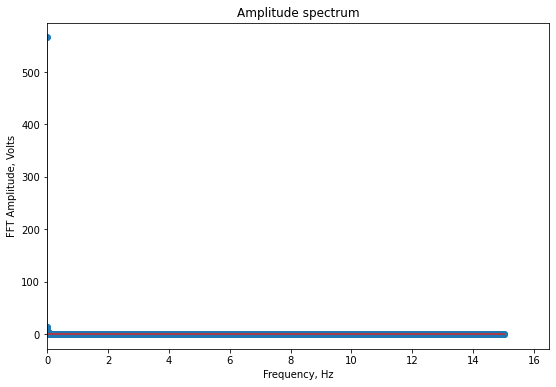

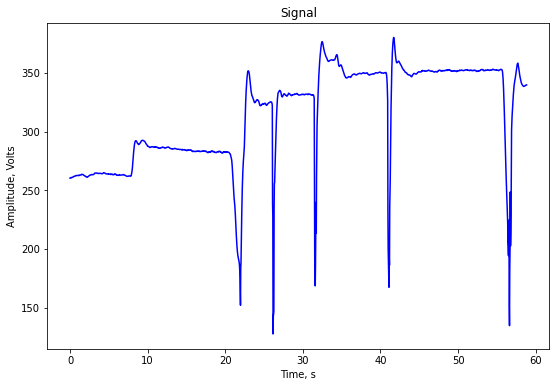

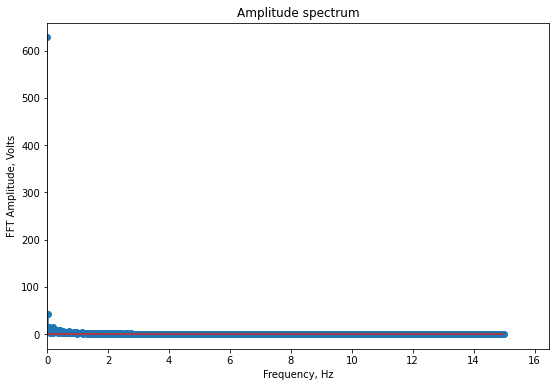

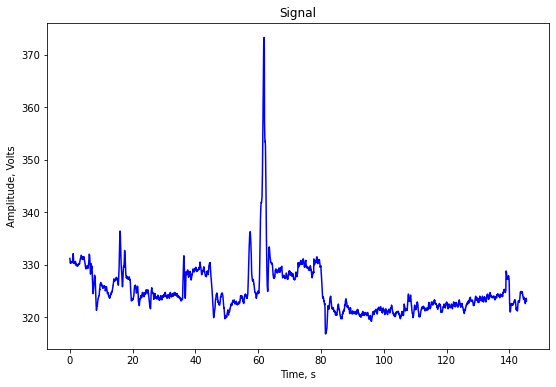

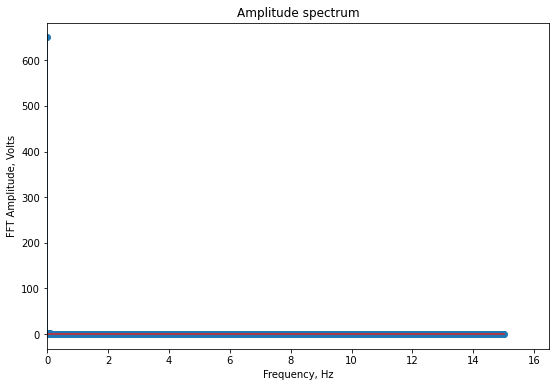

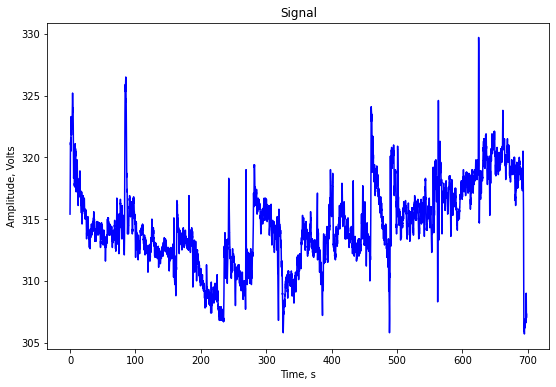

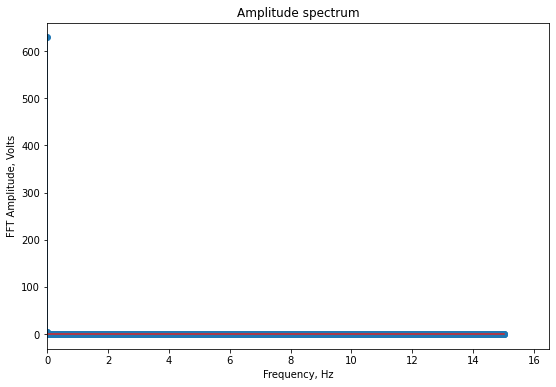

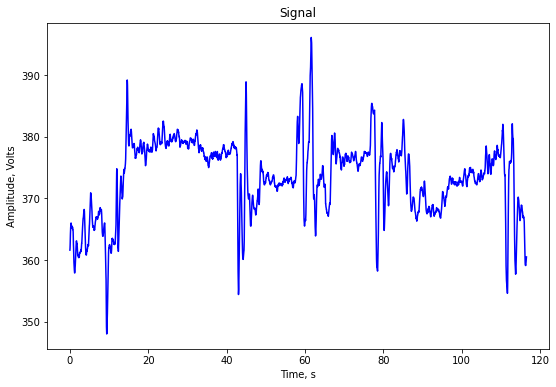

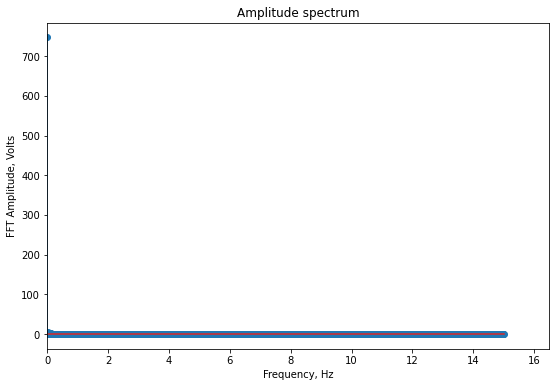

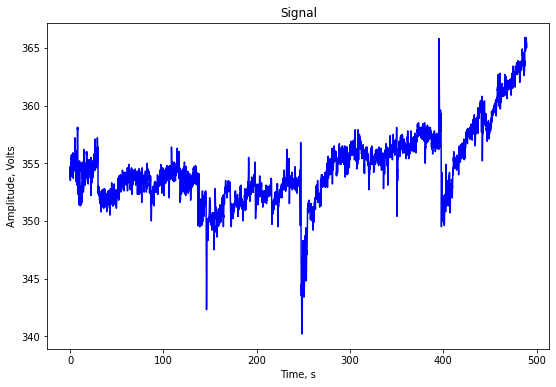

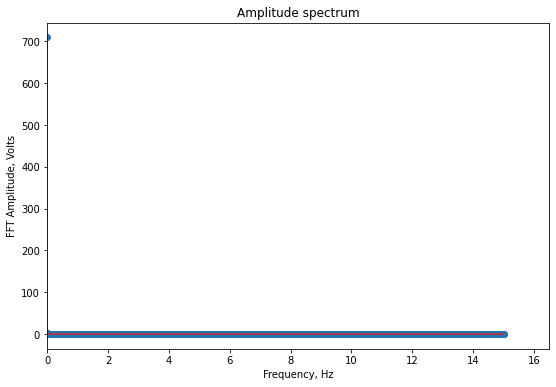

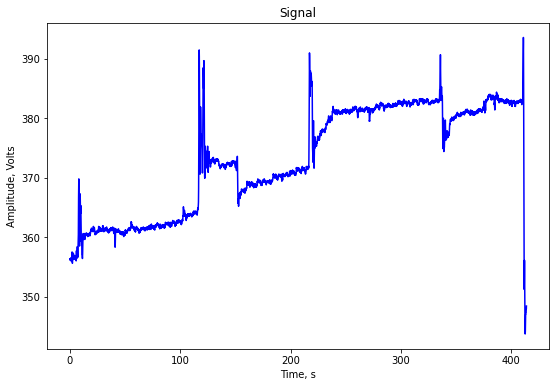

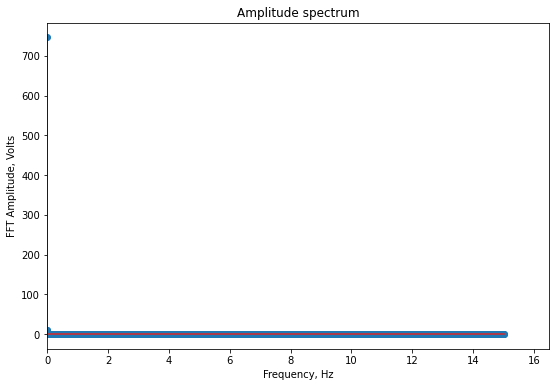

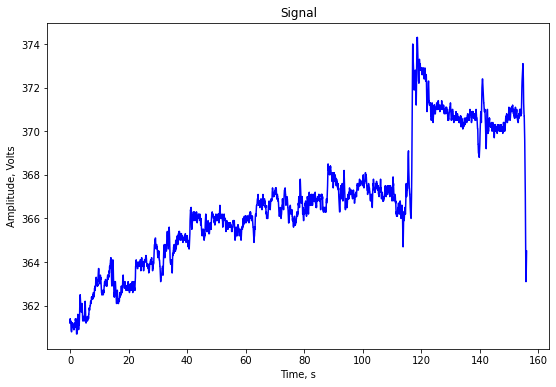

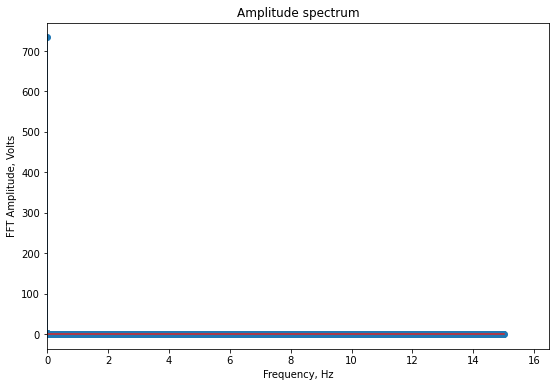

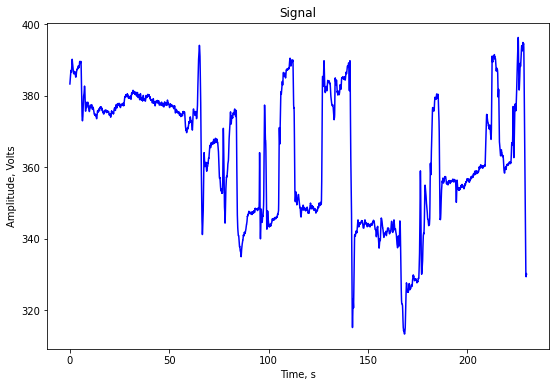

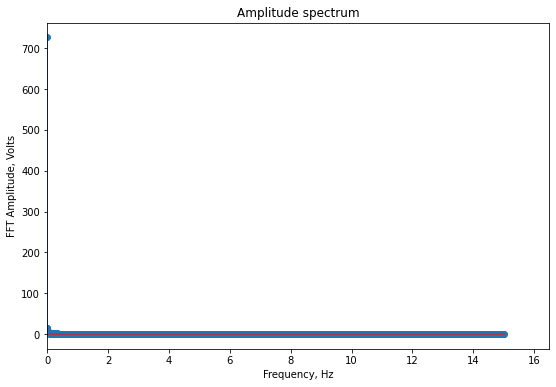

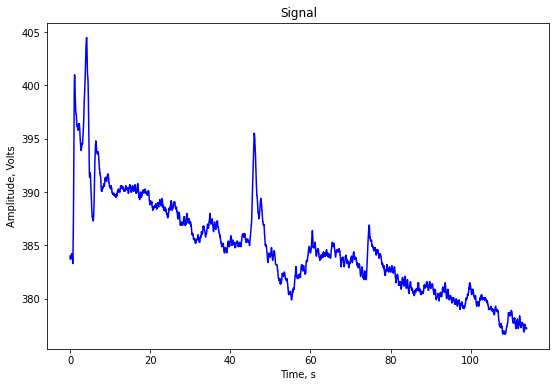

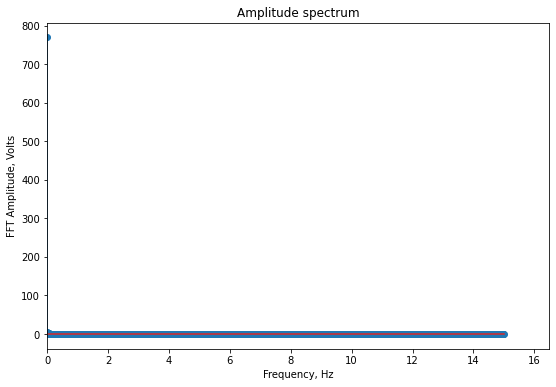

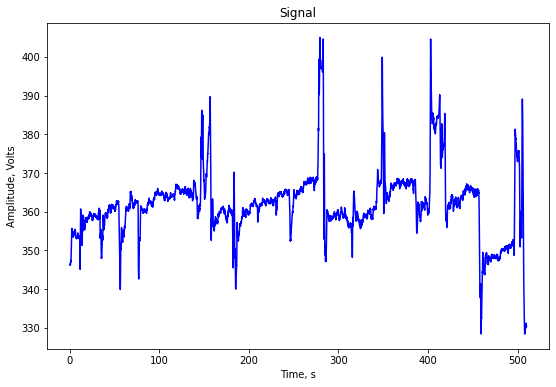

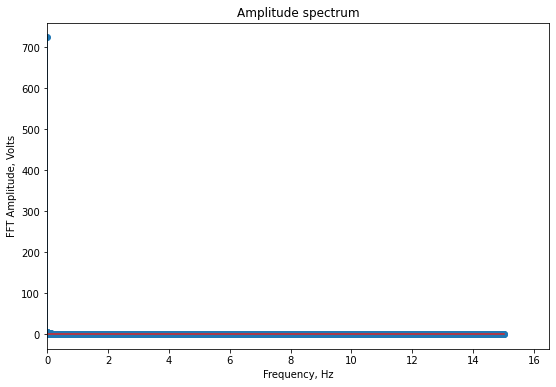

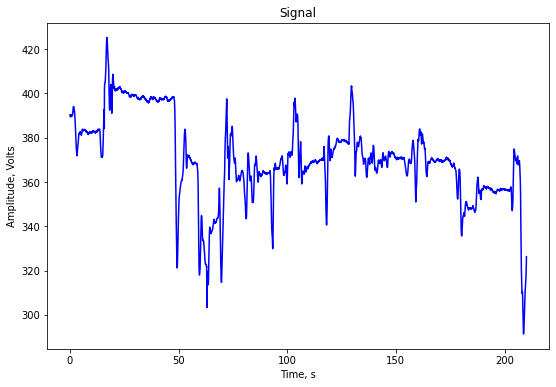

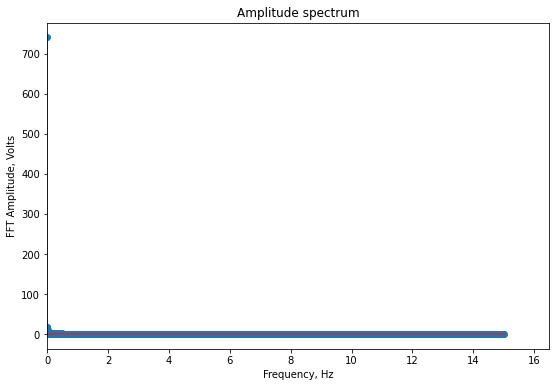

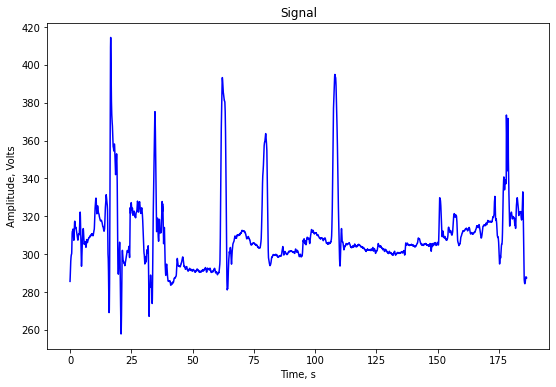

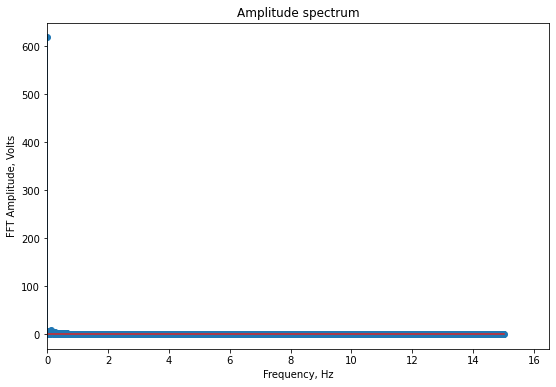

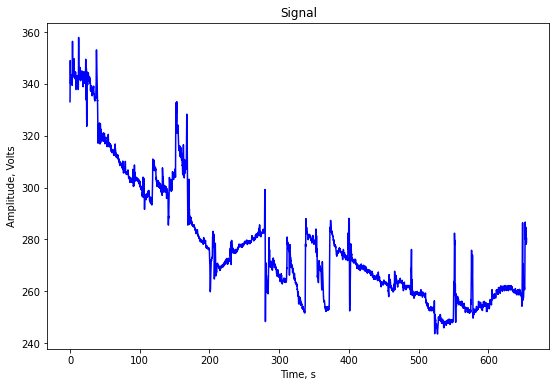

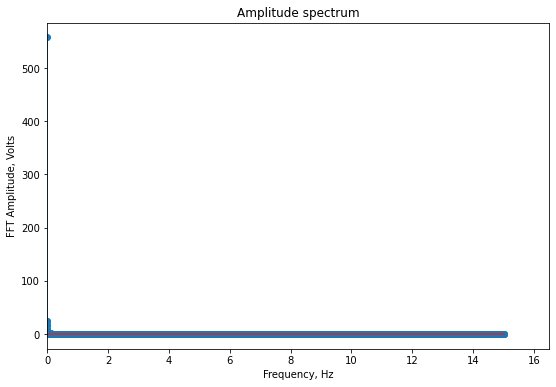

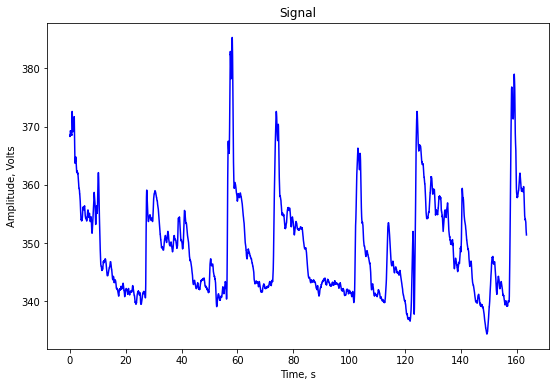

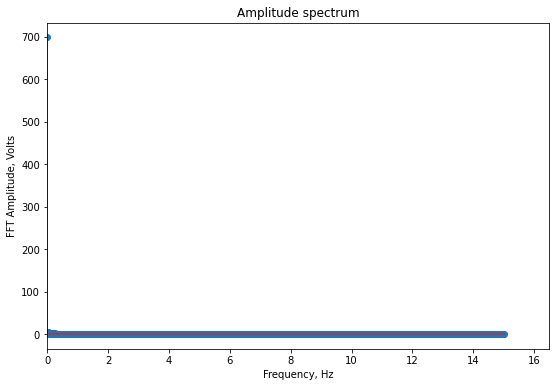

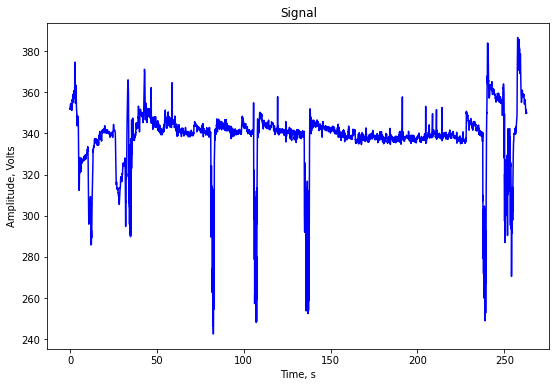

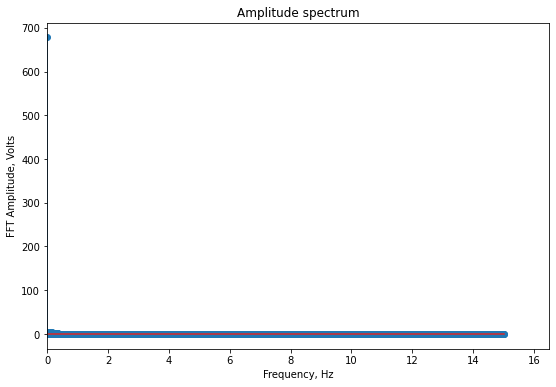

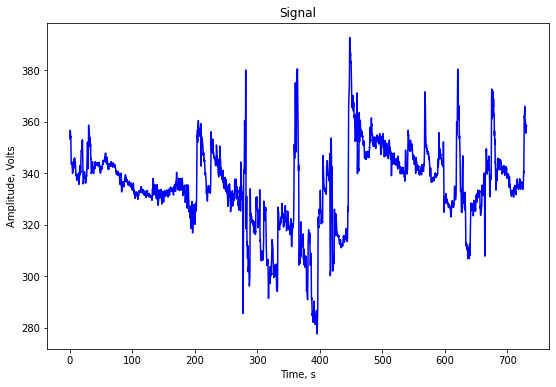

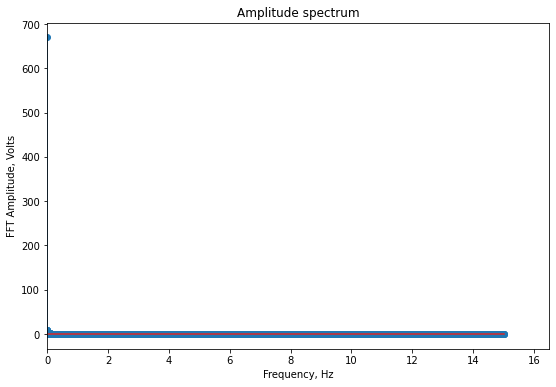

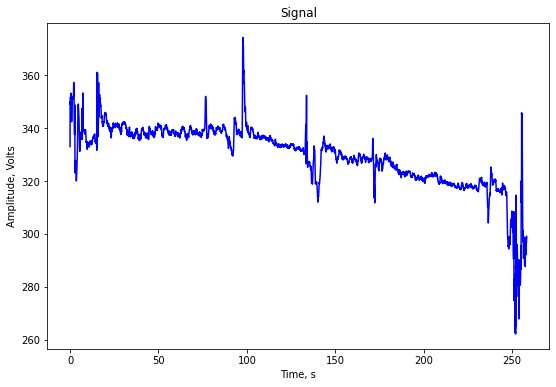

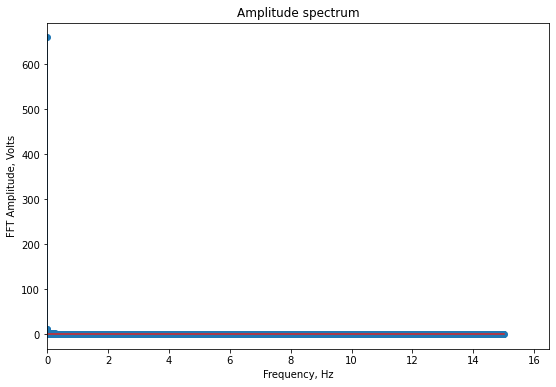

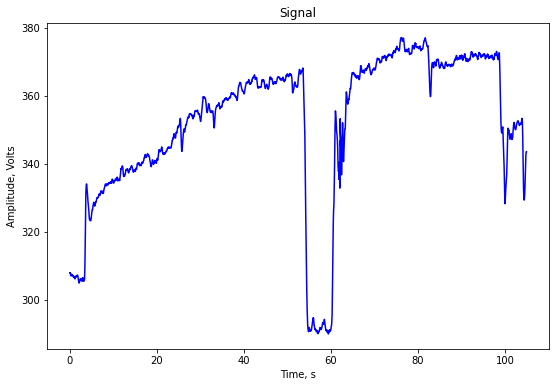

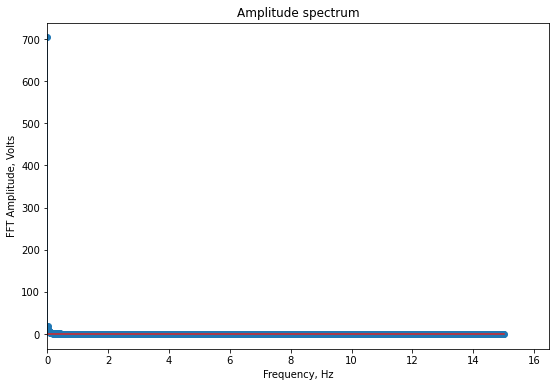

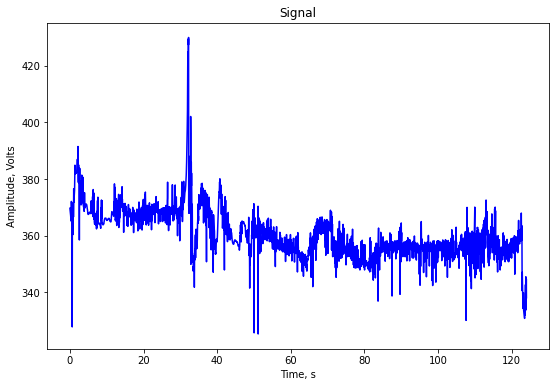

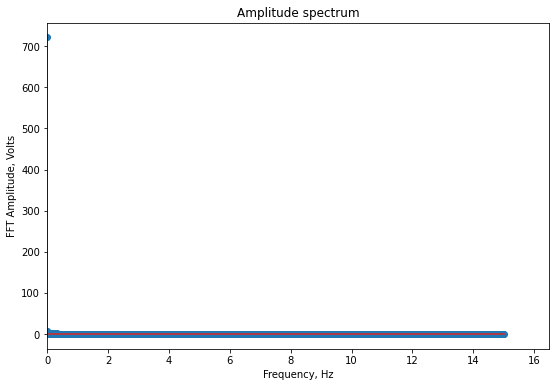

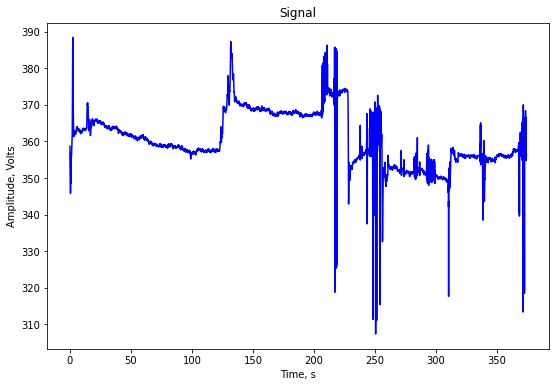

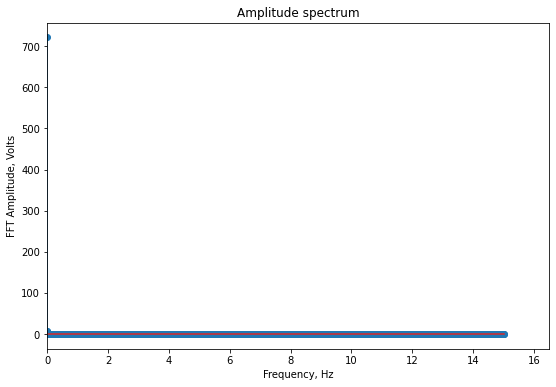

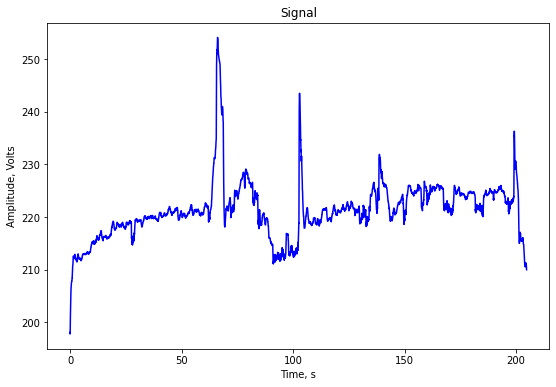

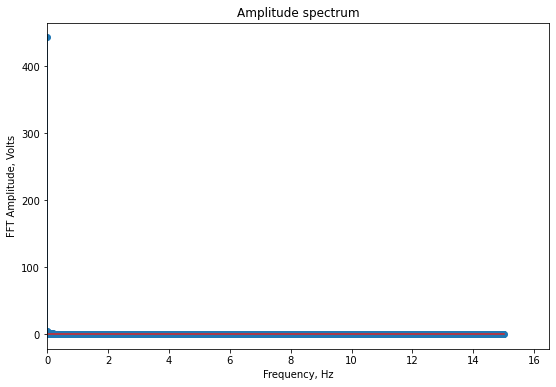

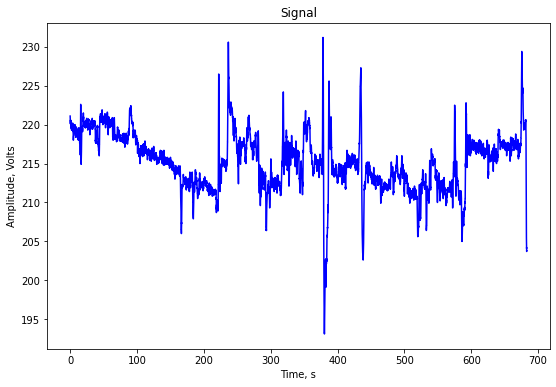

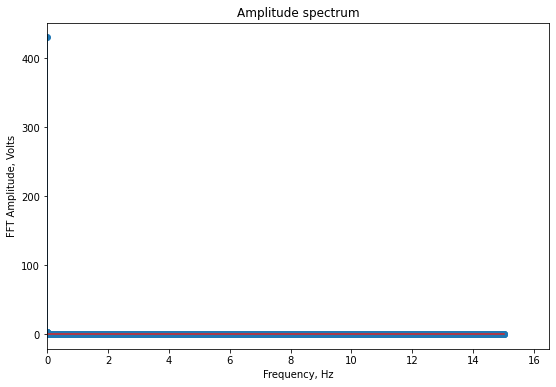

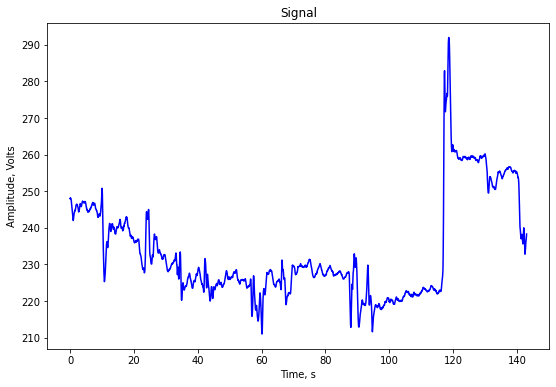

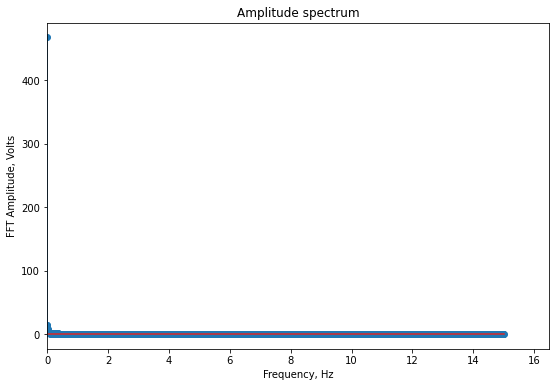

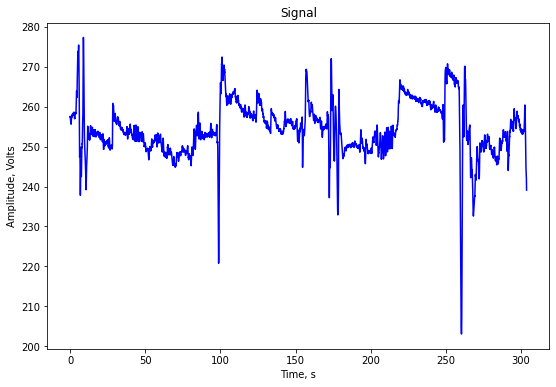

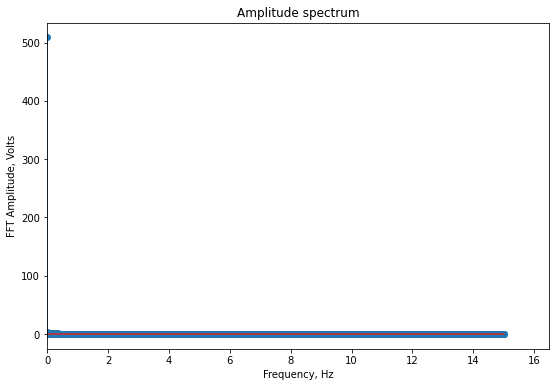

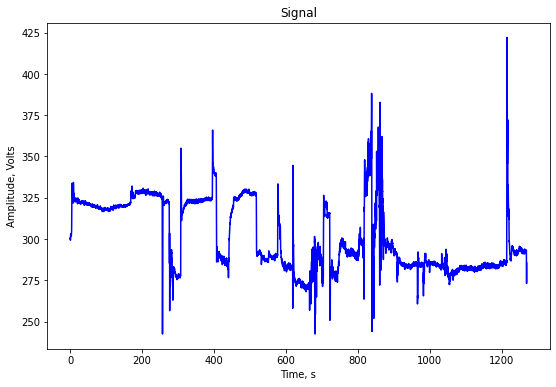

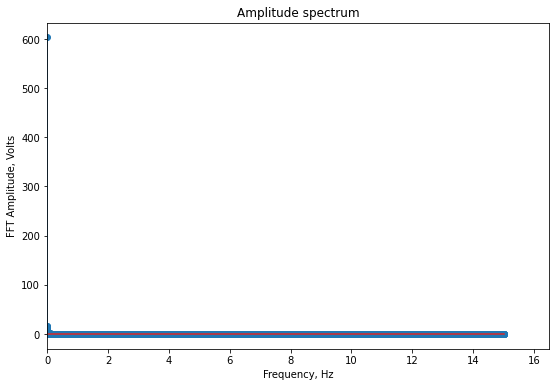

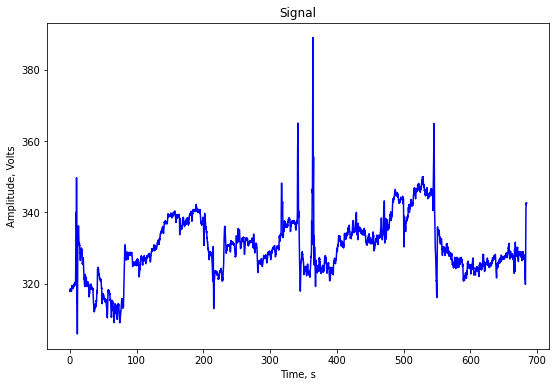

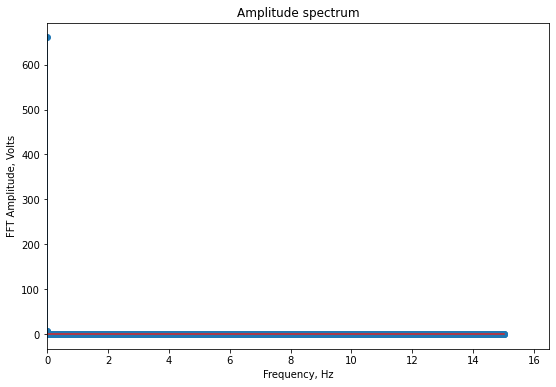

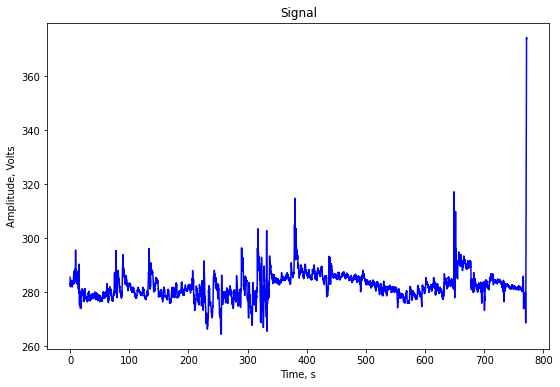

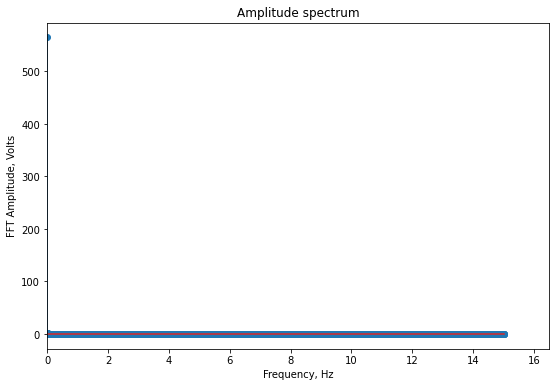

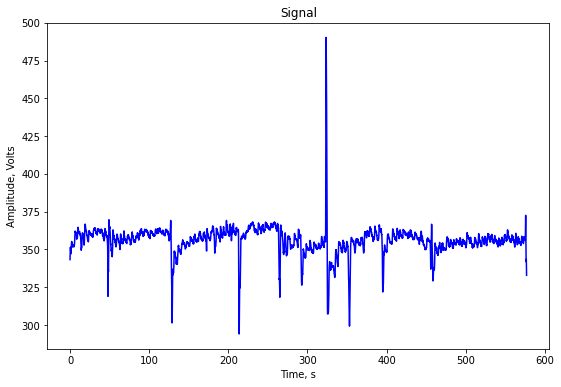

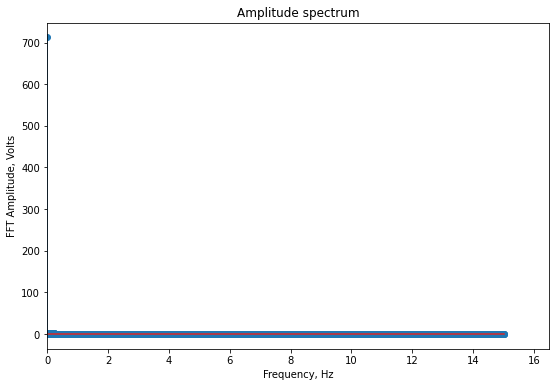

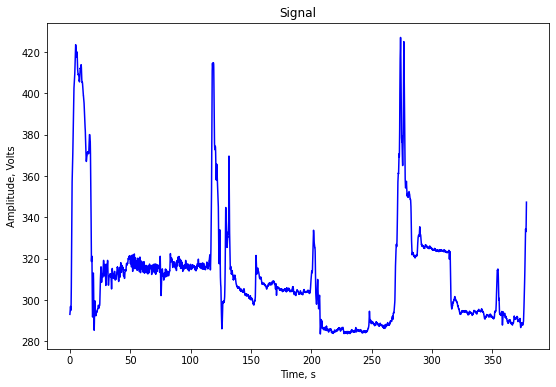

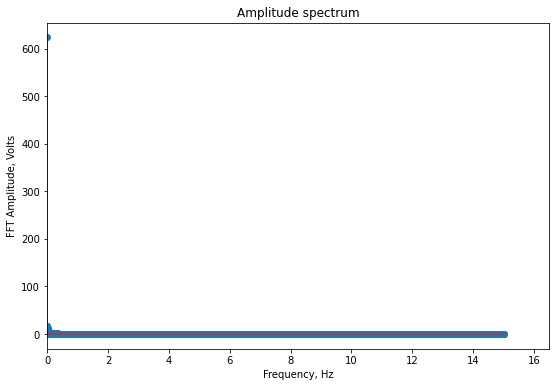

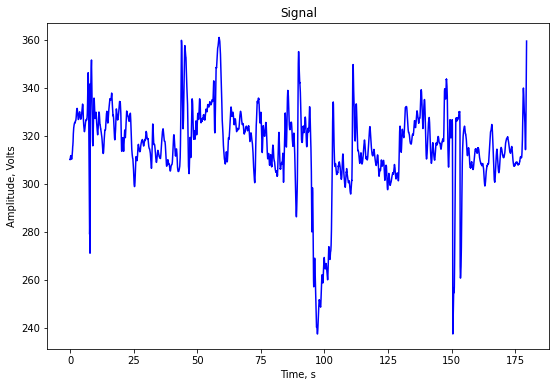

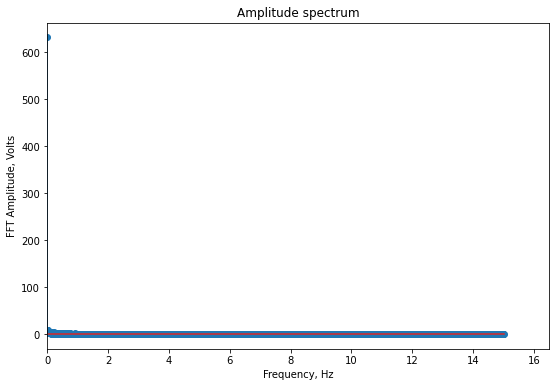

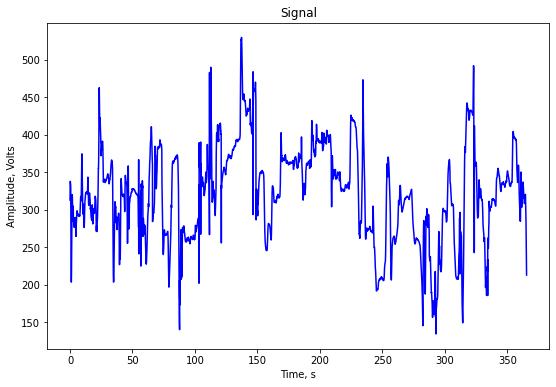

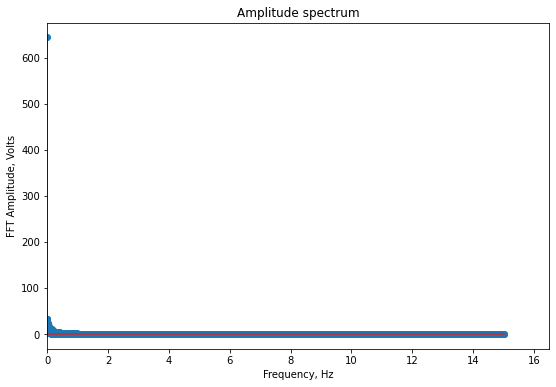

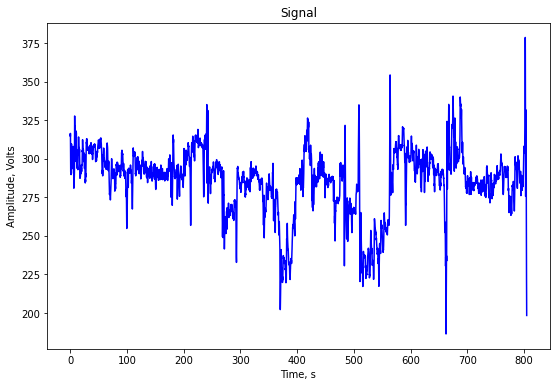

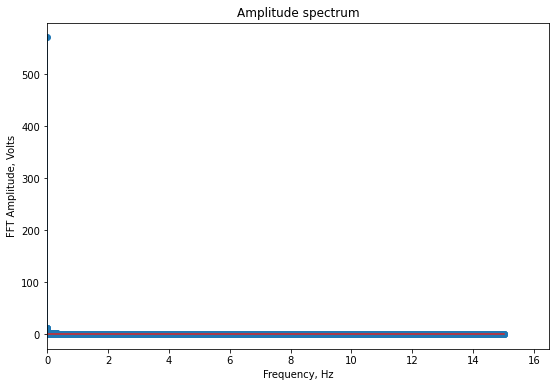

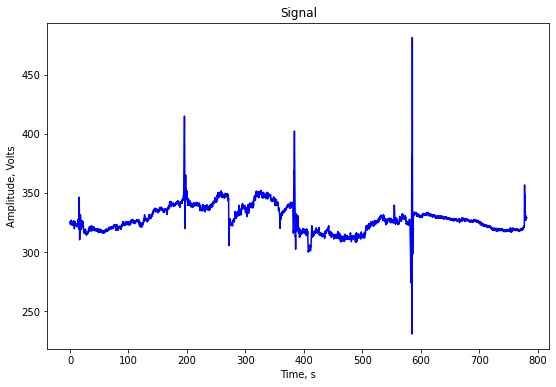

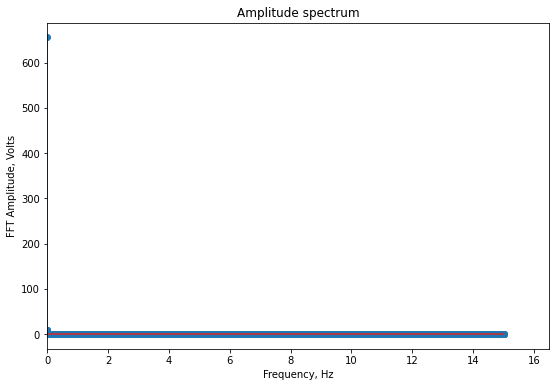

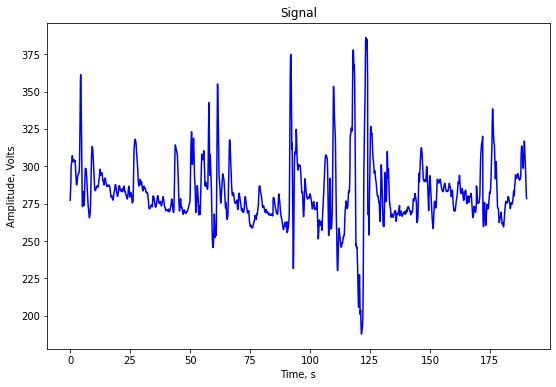

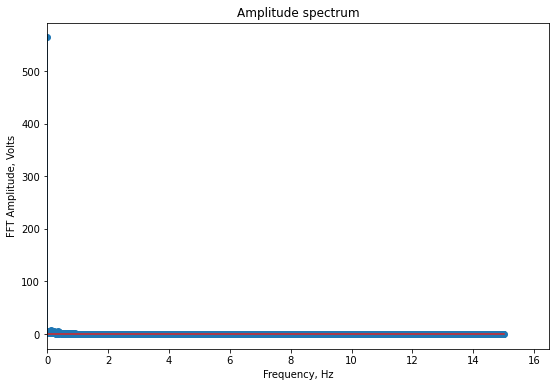

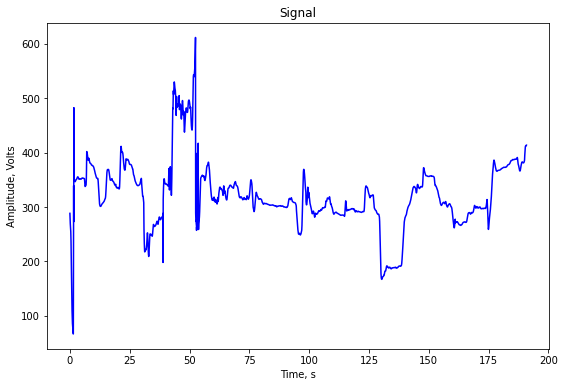

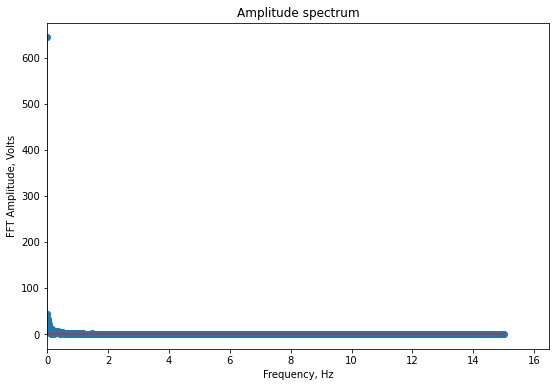

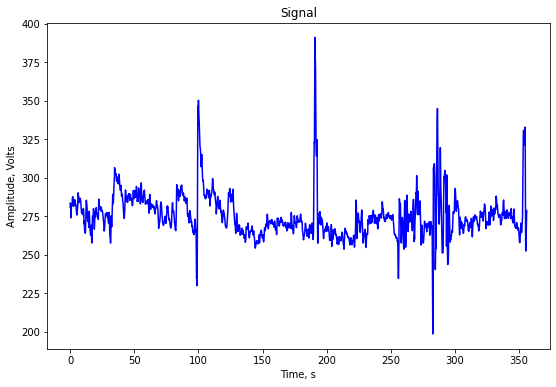

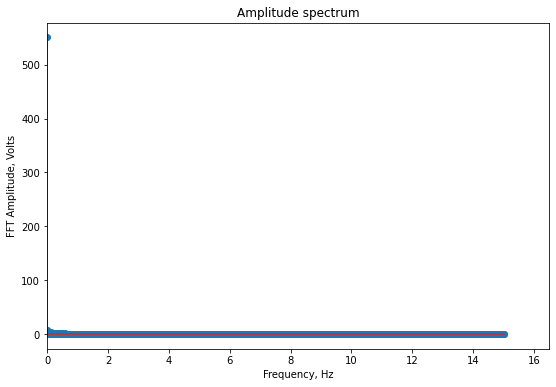

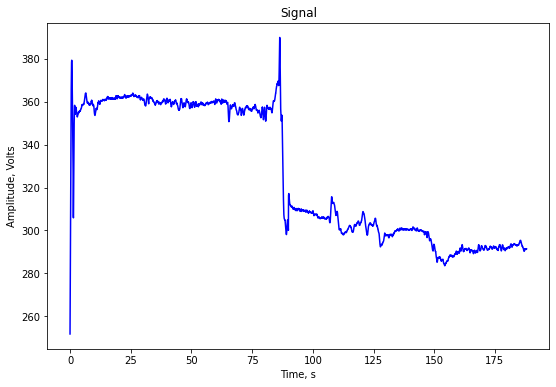

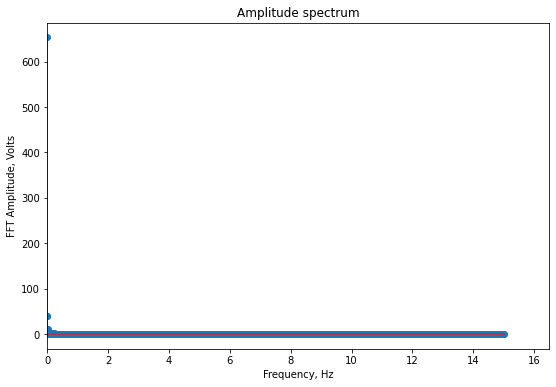

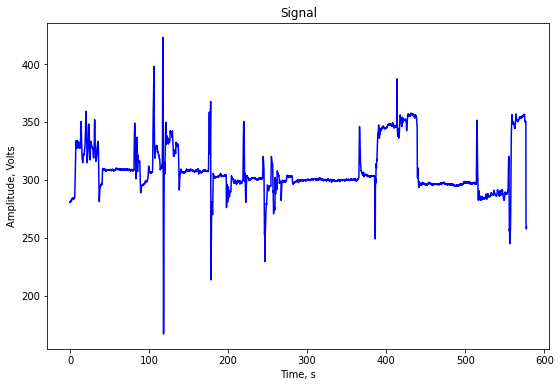

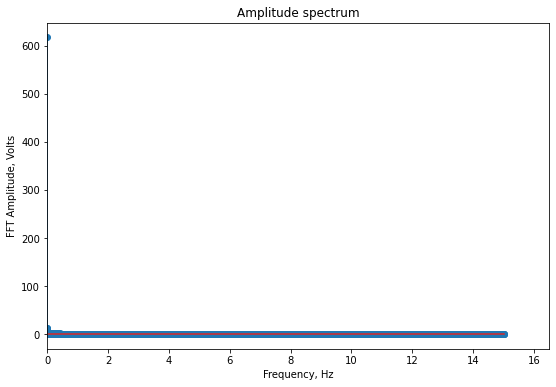

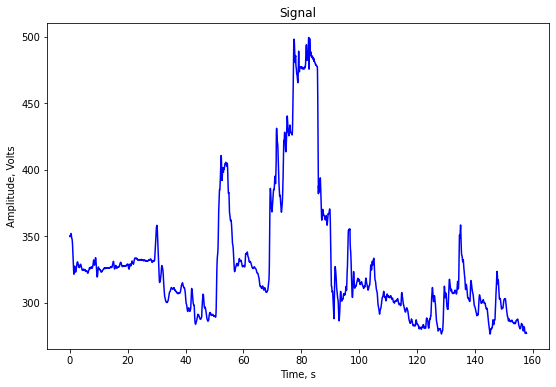

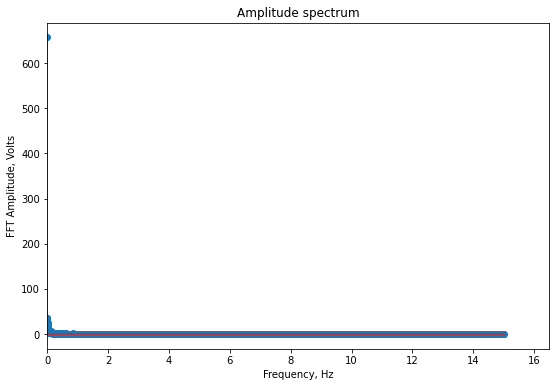

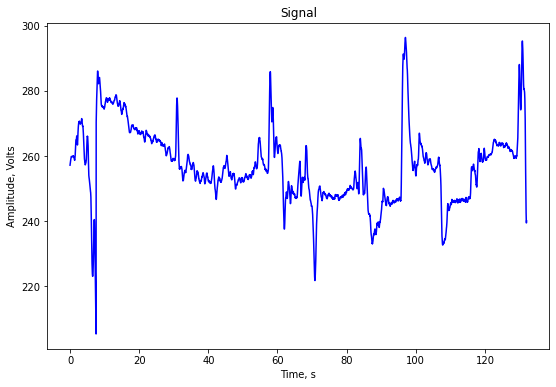

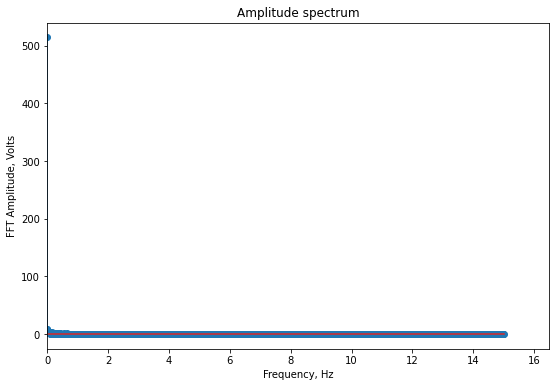

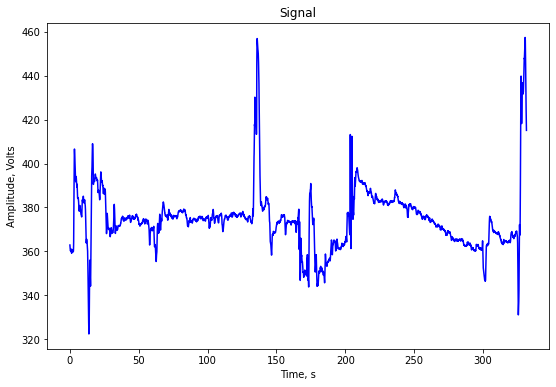

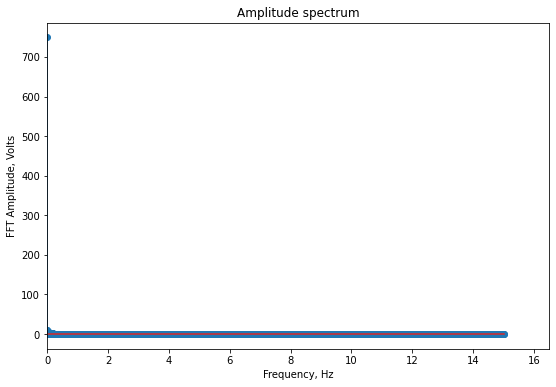

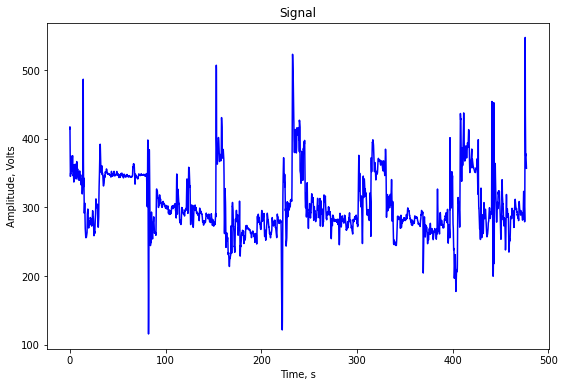

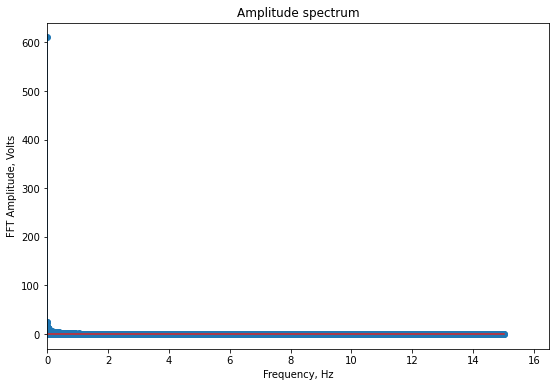

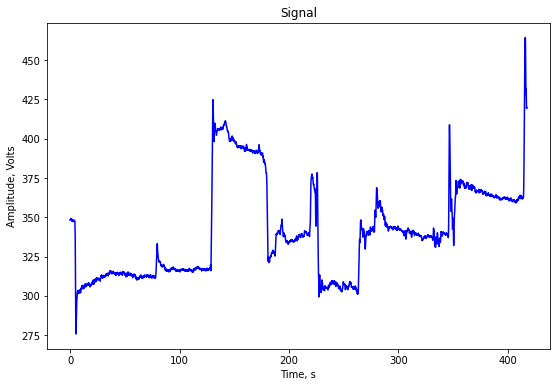

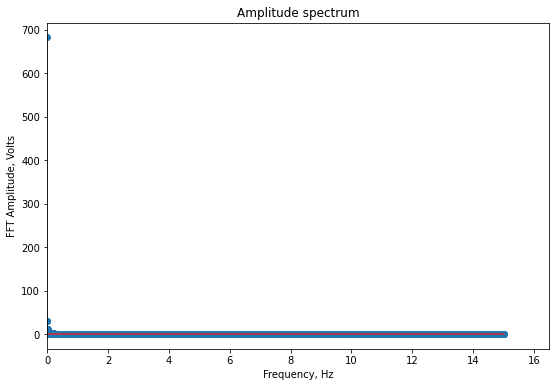

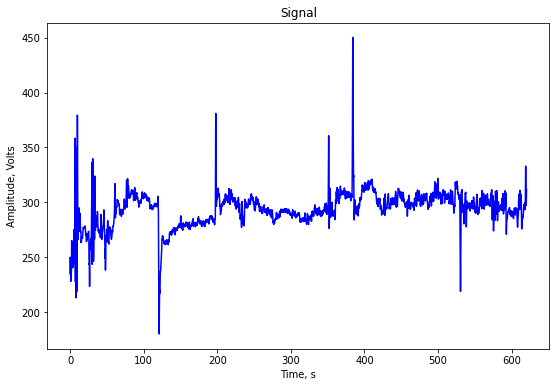

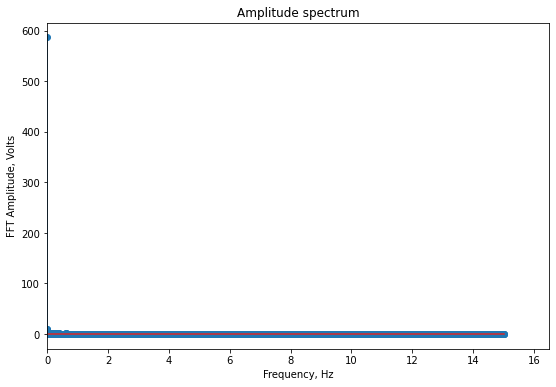

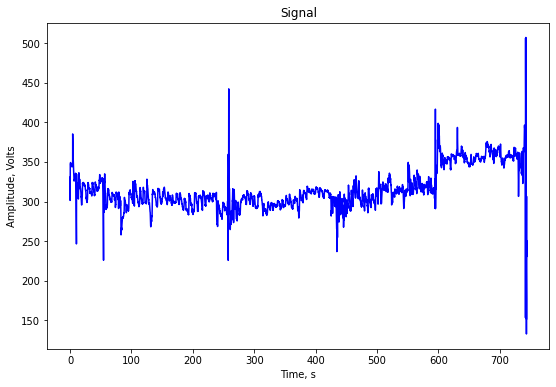

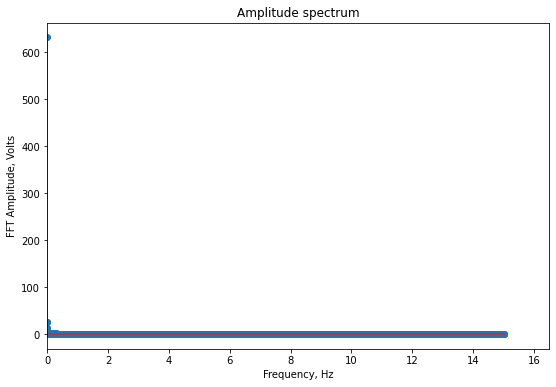

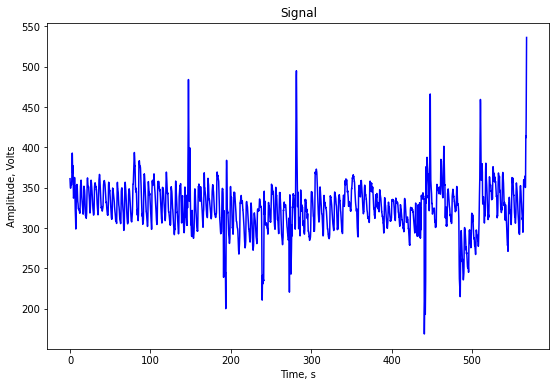

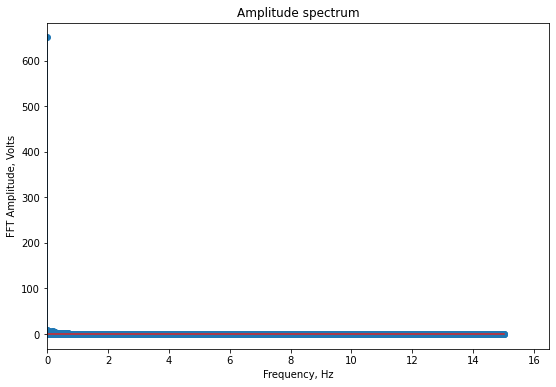

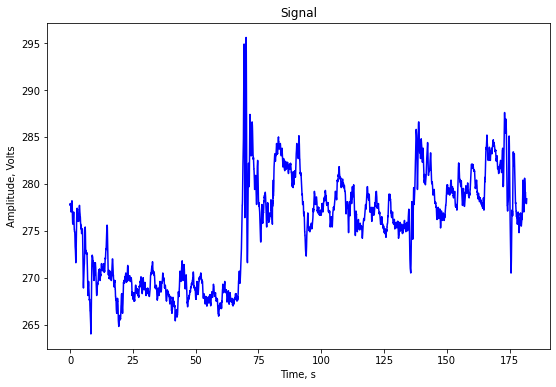

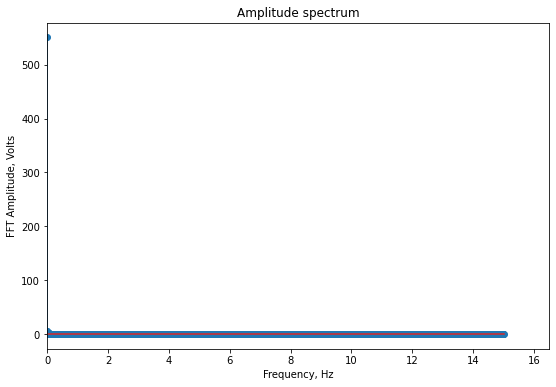

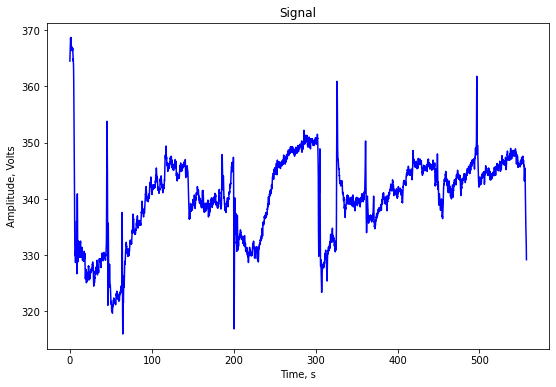

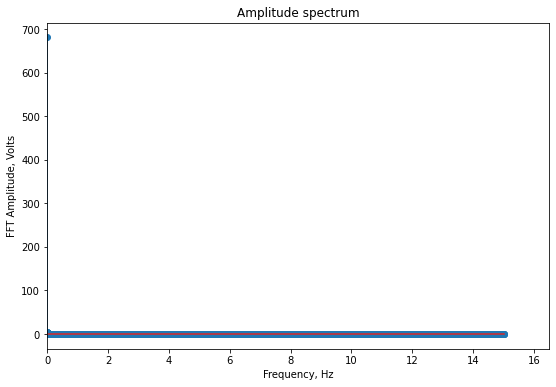

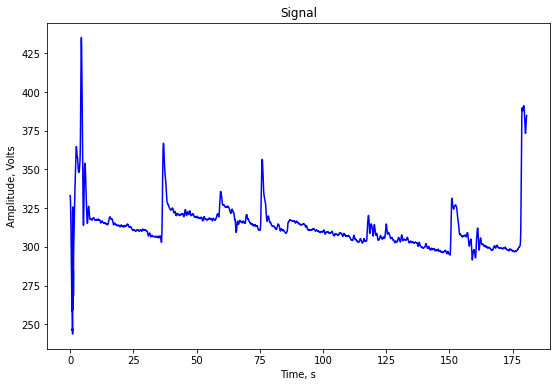

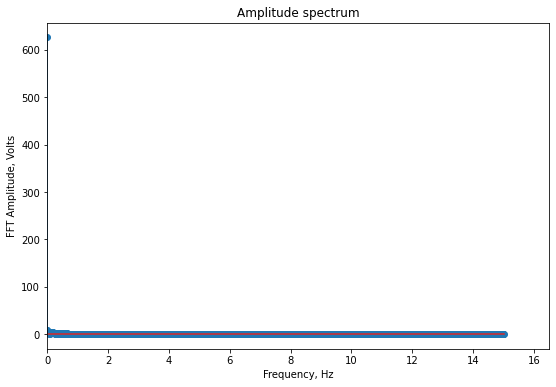

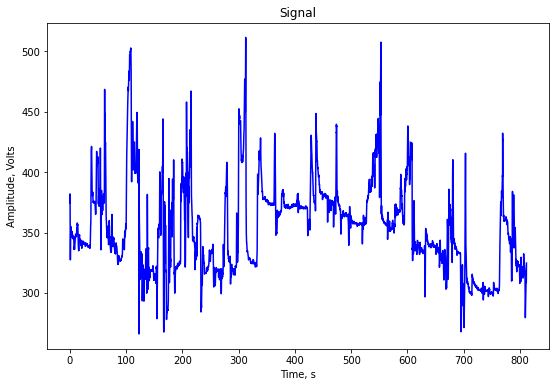

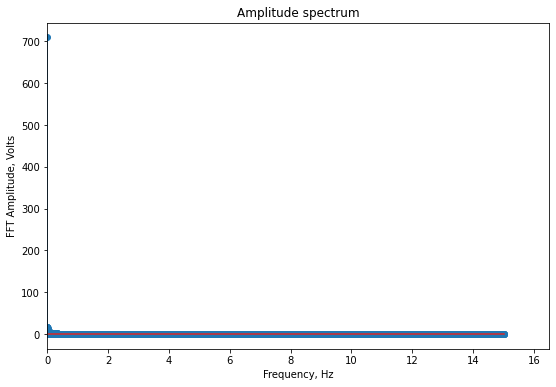

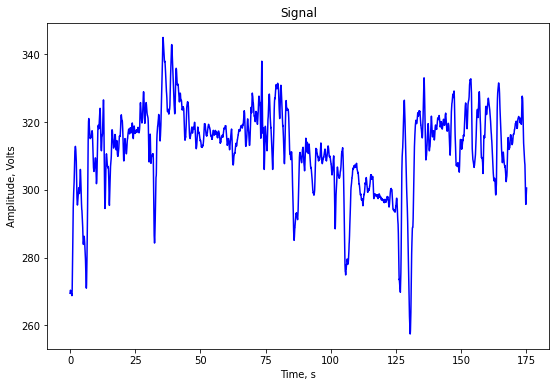

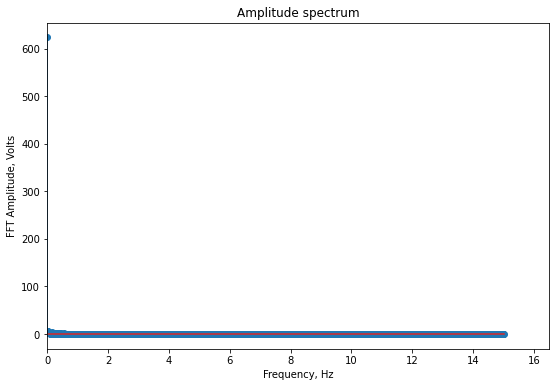

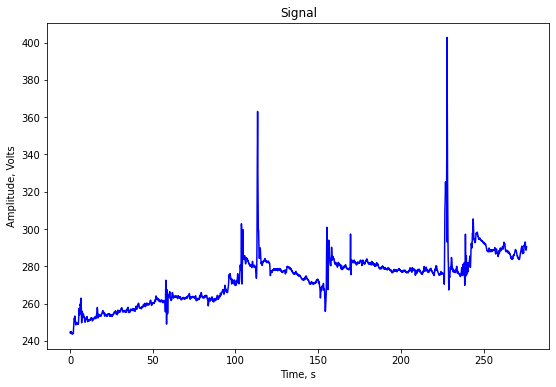

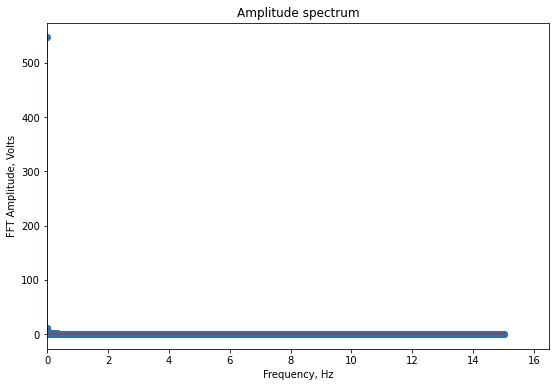

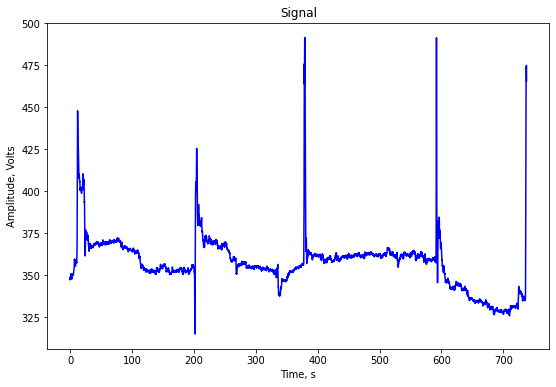

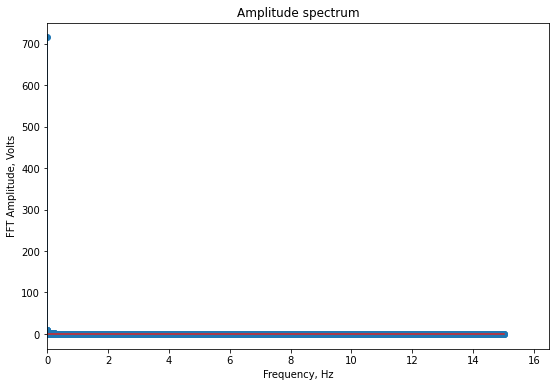

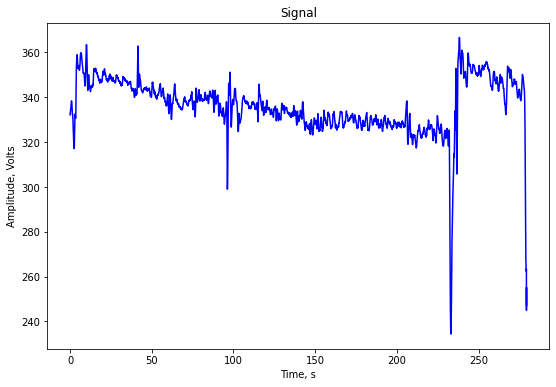

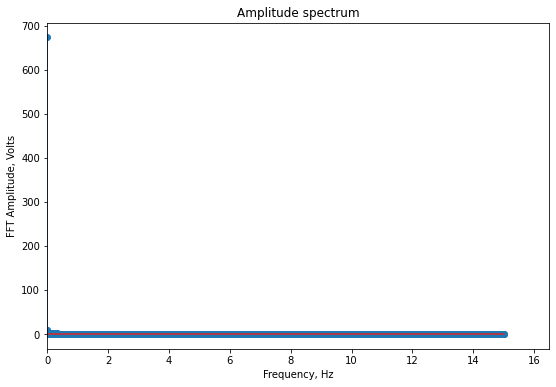

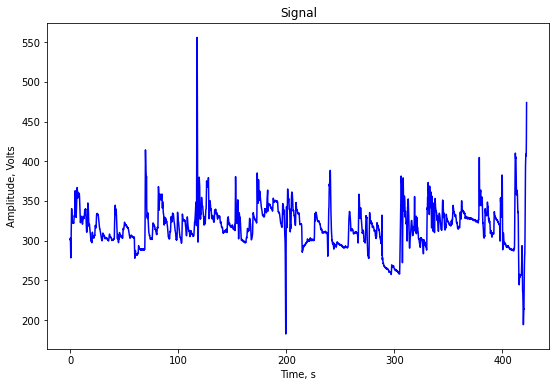

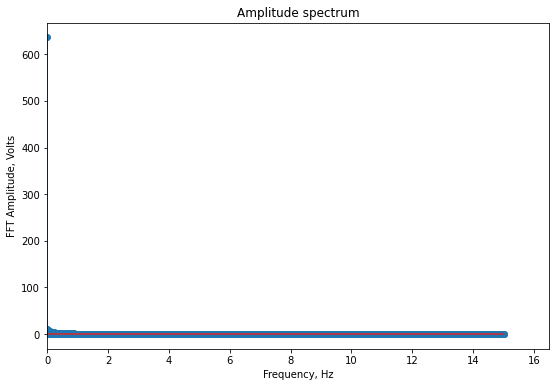

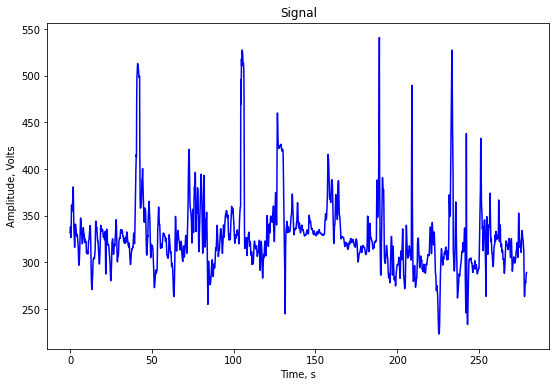

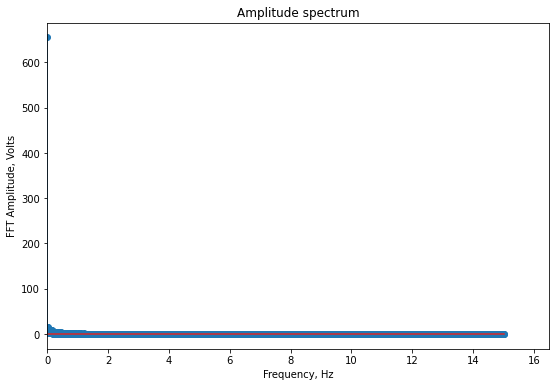

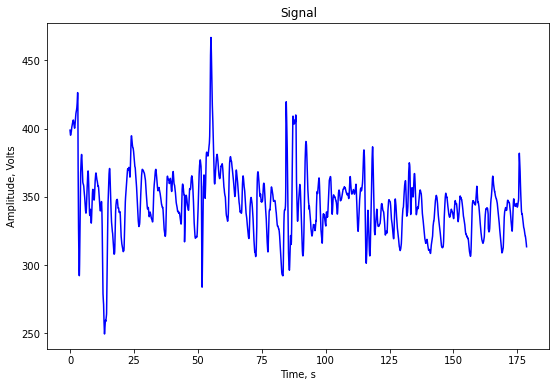

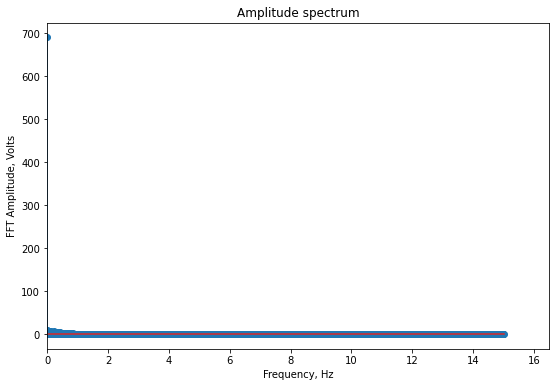

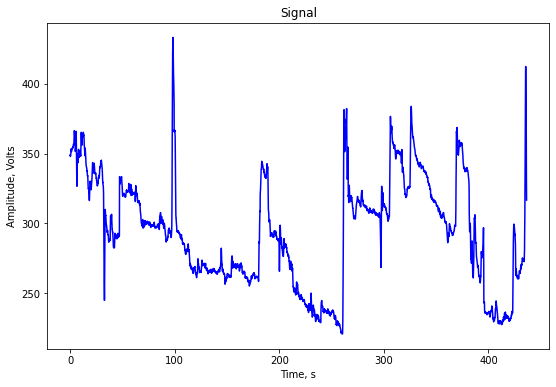

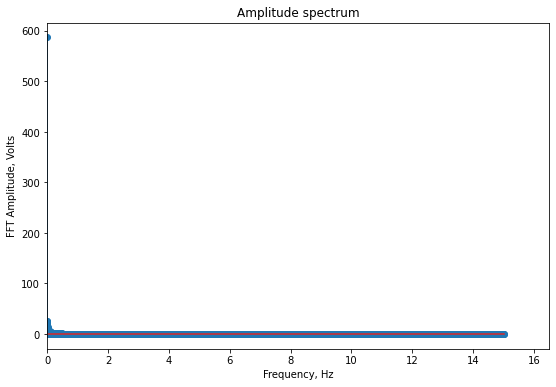

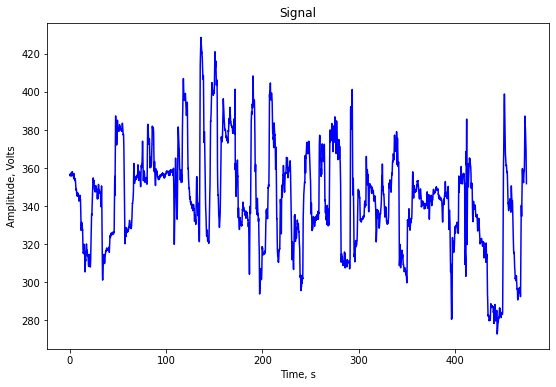

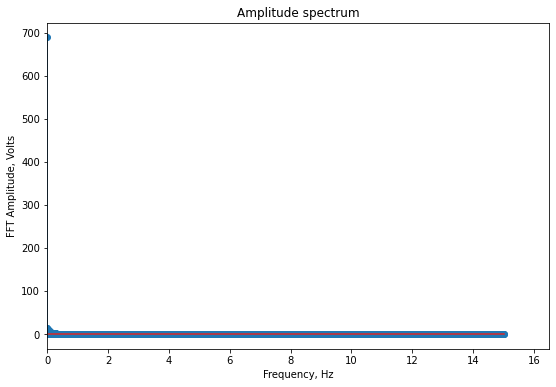

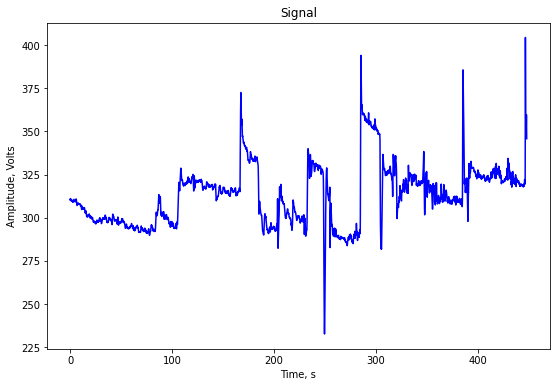

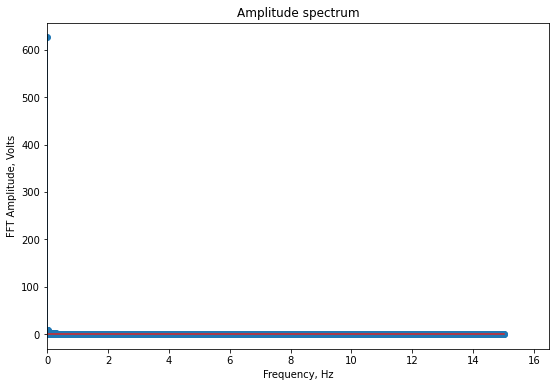

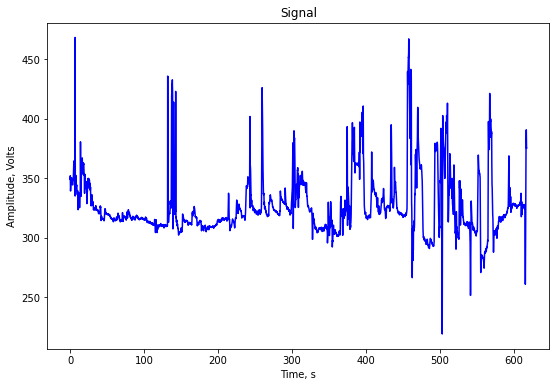

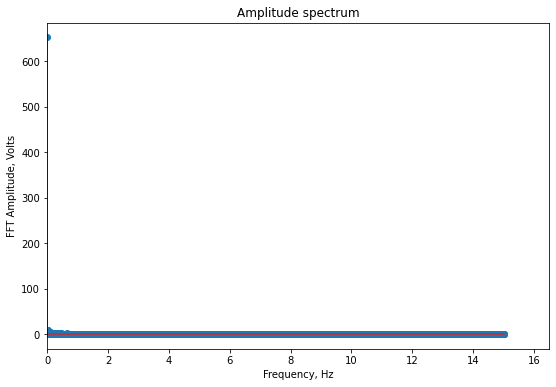

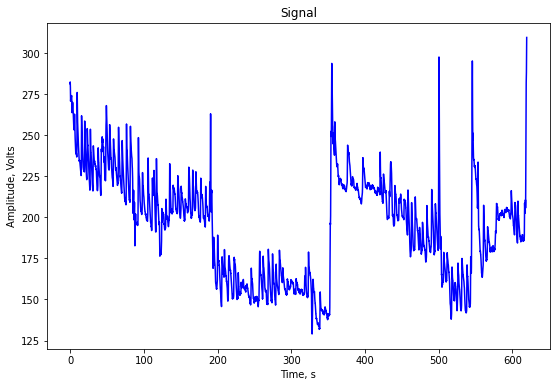

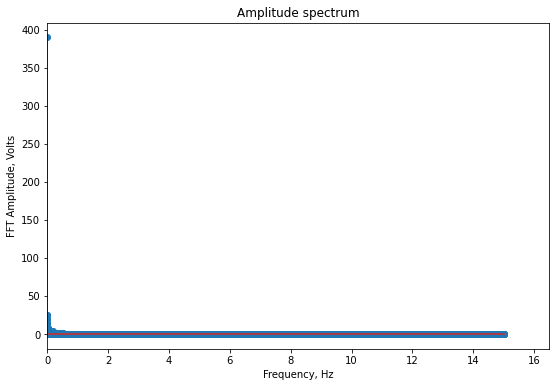

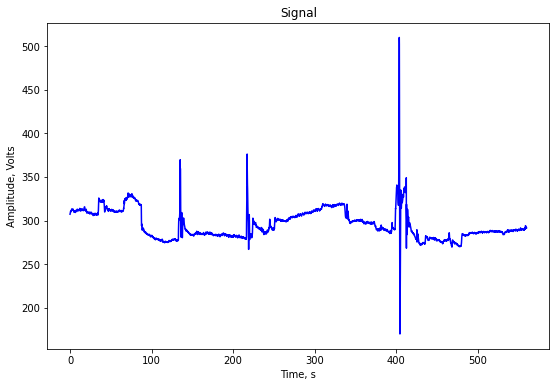

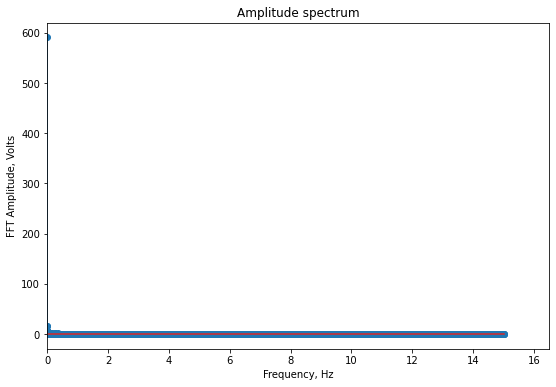

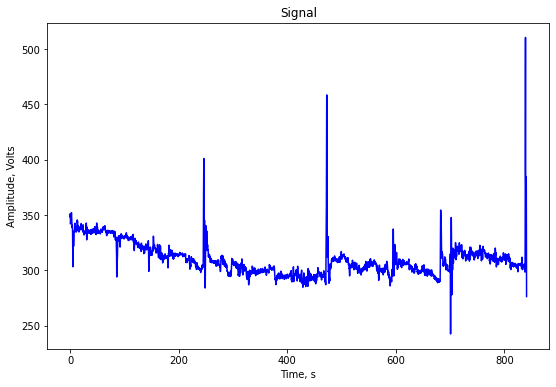

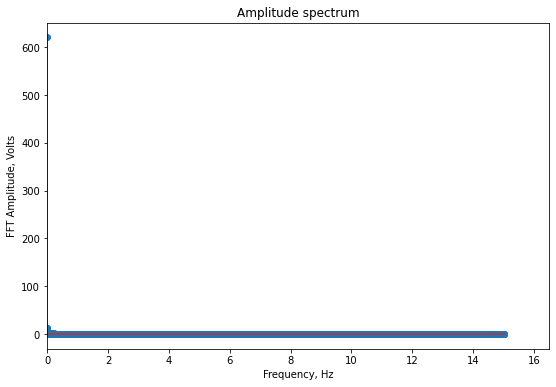

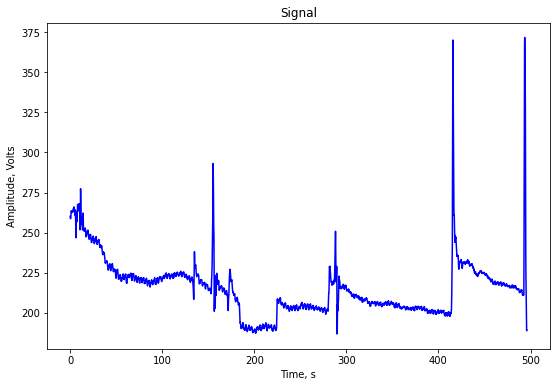

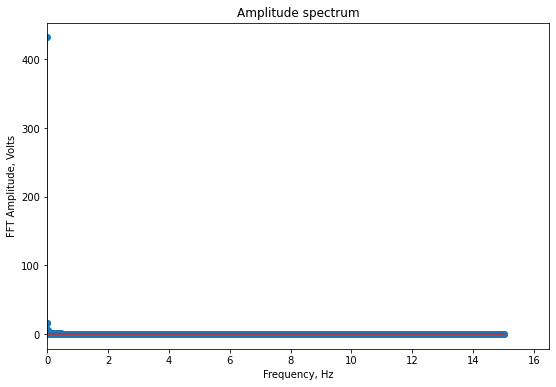

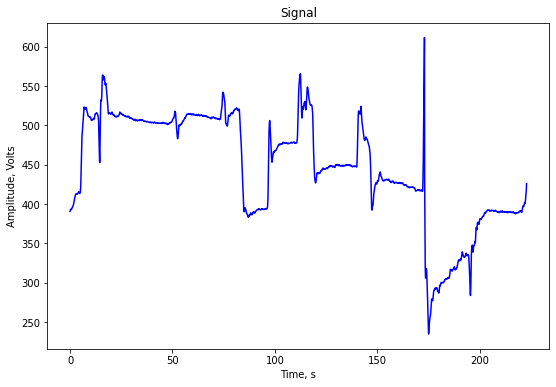

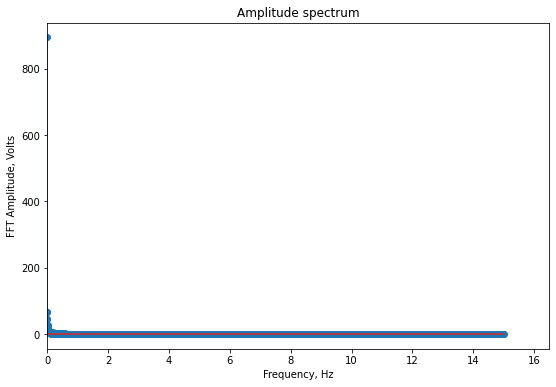

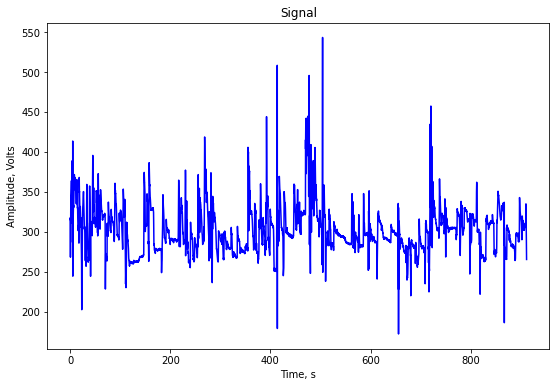

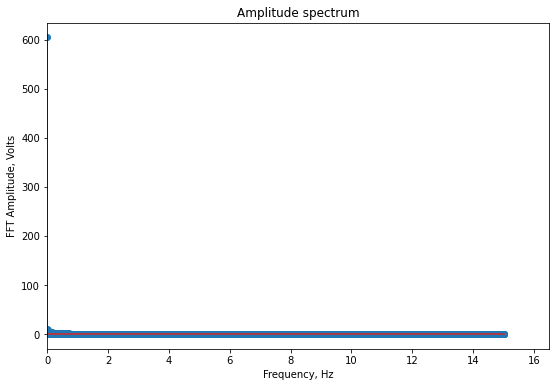

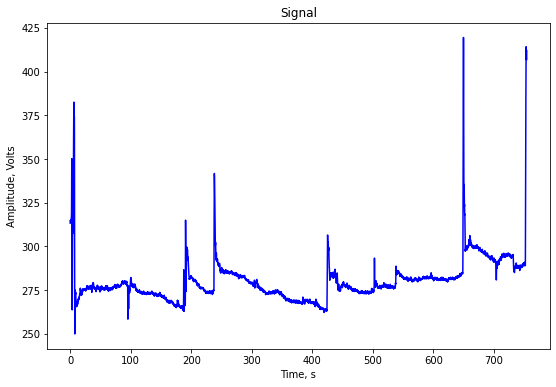

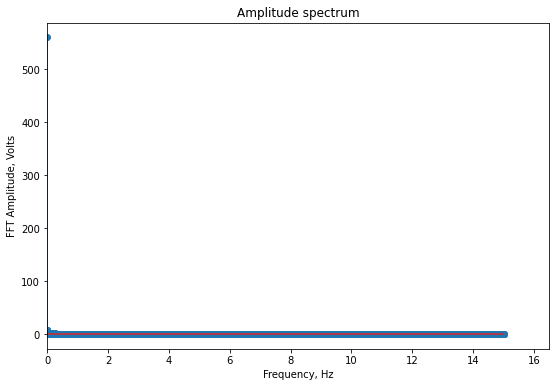

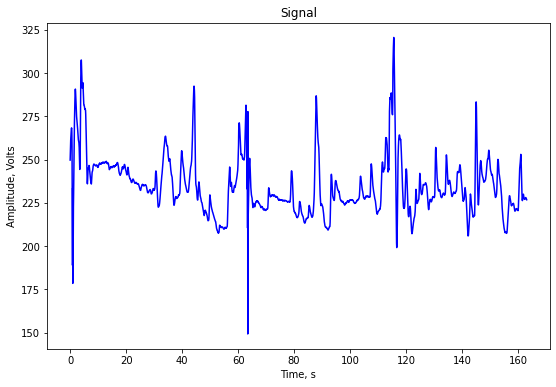

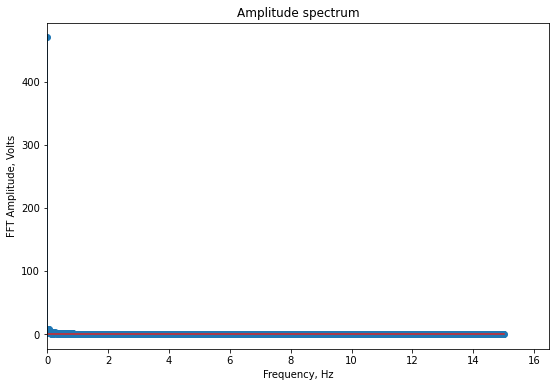

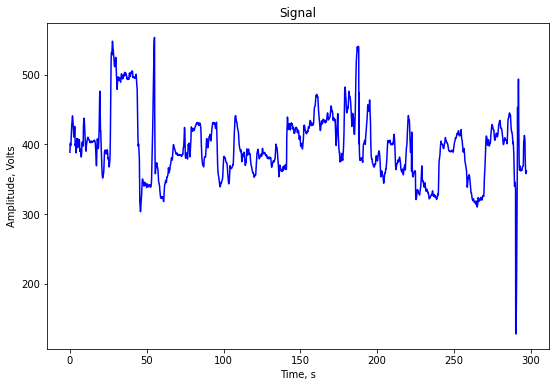

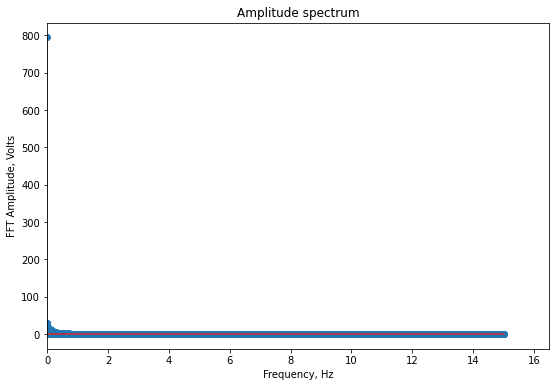

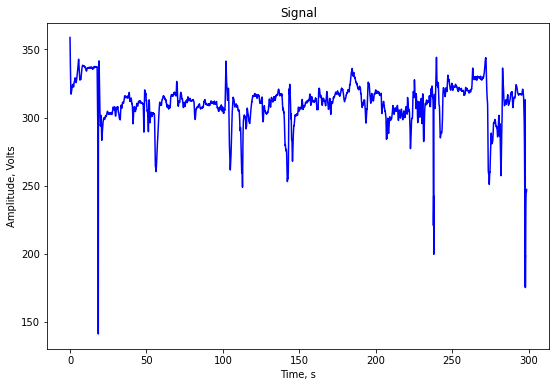

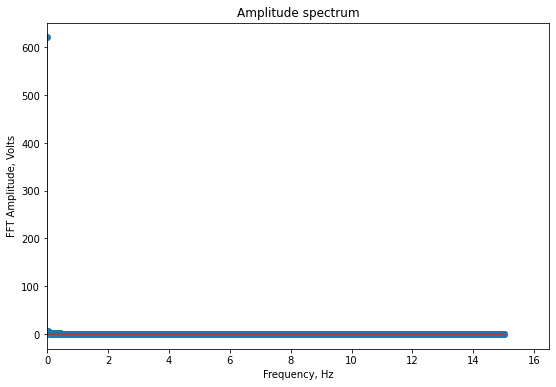

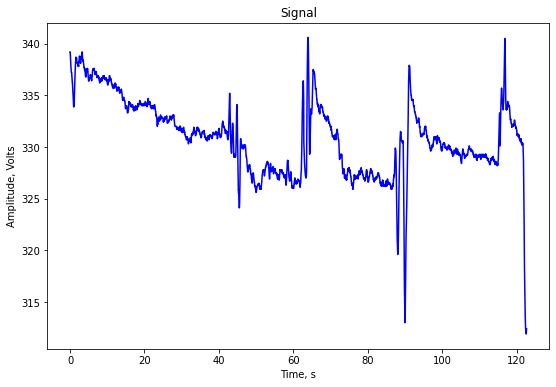

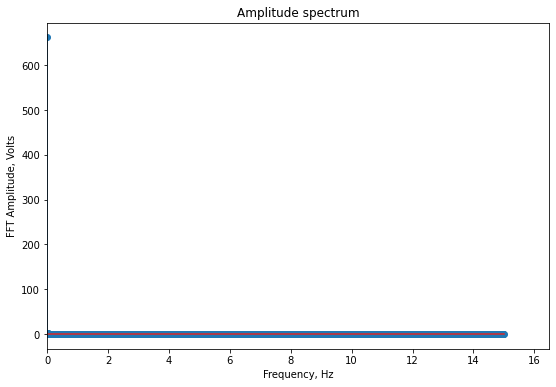

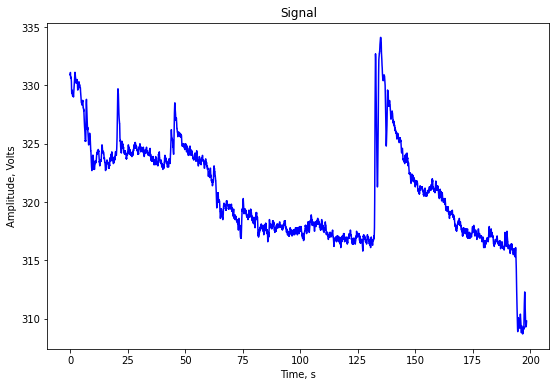

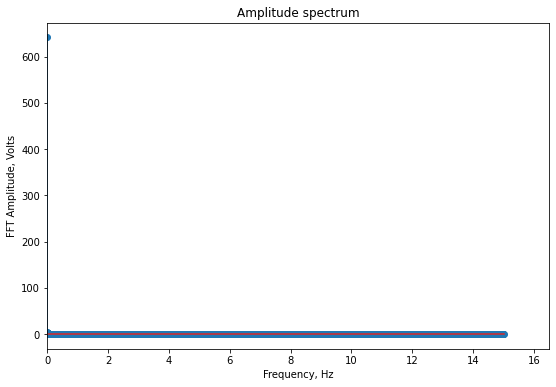

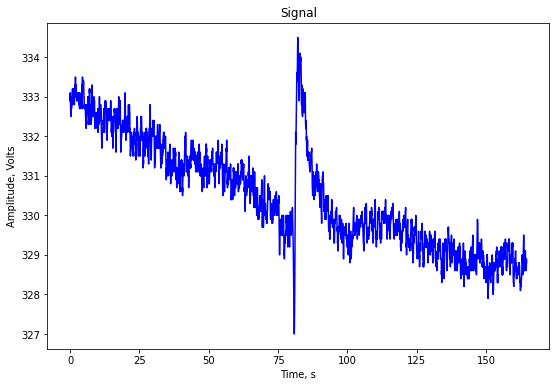

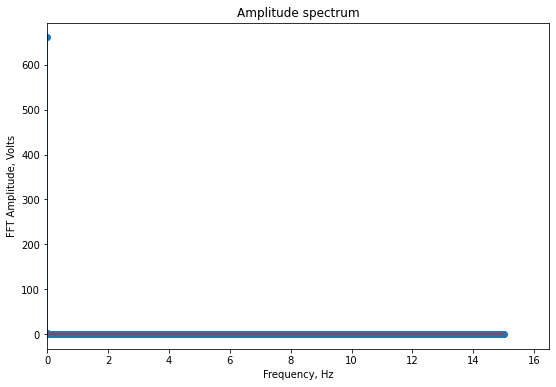

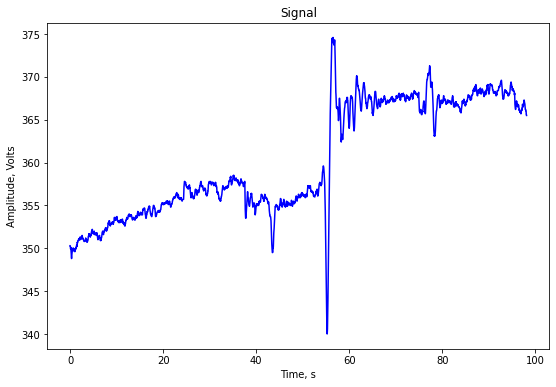

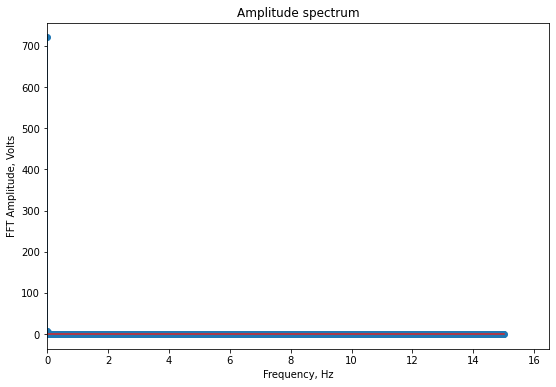

In [7]:
def fft_and_plot(x, y, fr):
    plt.figure(figsize=(9, 6))
    plt.title("Signal")
    plt.xlabel("Time, s")
    plt.ylabel("Amplitude, Volts")
    plt.plot(x, y, color='blue')
    plt.show()
    
    sp = np.fft.fft(y)
    freq = np.fft.fftfreq(n=x.shape[-1], d=1/fr)
    plt.figure(figsize=(9, 6))
    plt.stem(freq, np.abs(sp * 2 / len(freq)))
    plt.xlim(0,)
    plt.title("Amplitude spectrum")
    plt.xlabel("Frequency, Hz")
    plt.ylabel("FFT Amplitude, Volts")
    plt.show()
    
    positive_indices = freq >= 0
    sorted_indices = np.argsort(freq[positive_indices])
    sorted_freq = freq[sorted_indices]
    sorted_sp = np.abs(sp * 2 / len(freq))[sorted_indices]
    x1, x2, x3 = np.array_split(sorted_sp, 3)
    return x1.sum(), x2.sum(), x3.sum()
# np.mean(np.abs(sp * 2 / len(freq))), np.min(np.abs(sp * 2 / len(freq))), np.max(np.abs(sp * 2 / len(freq)))


def fft_head_trajectory(session_id):
    x = df.loc[df['Session_id'] == session_id, 'X_HEAD'].tolist()[0]
    y = df.loc[df['Session_id'] == session_id, 'Y_HEAD'].tolist()[0]
#     N = 4
#     x1, x2, x3, x4 = np.array_split(x, N)
    dur = df.loc[df['Session_id'] == session_id, 'Duration_sec'].tolist()[0]
    fr = len(x) / dur
#     t = np.arange(0, dur / N, 1/fr)
    t = np.arange(0, dur, 1/fr)
    
#     print(len(x1), fr, 1/fr, len(np.arange(0, len(x1) / fr, 1/fr)))
#     print((len(x1)-1) / fr)
    x1, x2, x3 = fft_and_plot(np.linspace(0, (len(x)-1) / fr, len(x)), np.array(x), fr)
    return x1, x2, x3
    
#     x2_mean, x2_min, x2_max = fft_and_plot(np.linspace(0, (len(x2)-1) / fr, len(x2)), np.array(x2), fr)
#     x3_mean, x3_min, x3_max = fft_and_plot(np.linspace(0, (len(x3)-1) / fr, len(x3)), np.array(x3), fr)
#     x4_mean, x4_min, x4_max = fft_and_plot(np.linspace(0, (len(x4)-1) / fr, len(x4)), np.array(x4), fr)
#     return np.mean(np.array([x1_mean, x2_mean, x3_mean, x4_mean])), \
#             np.mean(np.array([x1_min, x2_min, x3_min, x4_min])), \
#             np.mean(np.array([x1_max, x2_max, x3_max, x4_max]))

# df[["Mean_sp_an", "Min_sp_an", "Max_sp_an"]] = df["Session_id"].apply(lambda x: pd.Series(fft_head_trajectory(x)))
df[["Low_sp", "Med_sp", "High_sp"]] = df["Session_id"].apply(lambda x: pd.Series(fft_head_trajectory(x)))

# fft_head_trajectory('0vDqTTS4iDY6DF5NOp8f')

In [8]:
df

,Session_id,BPOGX,BPOGY,X_HEAD,Y_HEAD,Left_closed,Right_closed,Valid_data,Session_desc,Duration_sec,Screen_width,Screen_height,Screen_ratio,Read_score,Filtered_BPOGX,Filtered_BPOGY,Valid_duration,Low_sp,Med_sp,High_sp
0,0vDqTTS4iDY6DF5NOp8f,"[-35.0, 0.2, 48.9, 88.0, 126.2, 146.3, 143.1, ...","[140.8, 140.3, 141.0, 140.6, 138.8, 137.2, 126...","[337.6, 337.6, 337.7, 337.7, 337.7, 337.7, 337...","[232.9, 233.2, 233.2, 233.8, 234.2, 234.6, 234...","[True, False, False, False, False, False, Fals...","[True, True, True, True, False, True, False, T...",1.000000,Normal Scan,273.000000,1366,768,1.00,NaN,"[0.2, 48.9, 88.0, 126.2, 146.3, 143.1, 134.2, ...","[140.3, 141.0, 140.6, 138.8, 137.2, 126.7, 124...",214.200000,754.350372,3.867108,2.661233
1,IxFK072TVWPwYlGys7rw,"[30.6, 82.9, 142.8, 184.7, 229.8, 283.6, 307.3...","[158.2, 154.7, 146.6, 132.5, 119.8, 135.6, 160...","[375.6, 375.6, 375.2, 375.0, 374.8, 374.0, 373...","[187.1, 187.1, 186.8, 186.6, 186.4, 185.7, 185...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",1.000000,Normal Read,185.500000,1366,768,1.00,4.0,"[30.6, 82.9, 142.8, 184.7, 229.8, 283.6, 307.3...","[158.2, 154.7, 146.6, 132.5, 119.8, 135.6, 160...",173.933333,795.044606,3.948930,2.718047
2,2N0kUSJASI5JIwtMnJ6Z,"[1242.9, 1260.6, 1243.1, 1222.5, 1206.1, 1169....","[319.1, 354.4, 394.2, 420.2, 421.9, 407.6, 386...","[387.3, 387.5, 387.6, 387.8, 387.8, 388.1, 388...","[282.8, 282.4, 282.3, 282.6, 282.9, 282.7, 282...","[True, True, False, False, False, False, False...","[True, True, False, False, False, False, False...",0.999344,Normal Scan,304.766667,1280,720,1.50,NaN,"[1242.9, 1260.6, 1243.1, 1222.5, 1206.1, 1169....","[319.1, 354.4, 394.2, 420.2, 421.9, 407.6, 386...",269.133333,870.763763,4.669314,3.428590
3,eVx48oKwJpOecNEasAHf,"[679.6, 692.7, 698.4, 711.4, 746.1, 843.4, 100...","[110.3, 107.4, 102.8, 109.5, 115.4, 132.1, 88....","[366.1, 366.2, 366.3, 366.2, 366.3, 366.3, 366...","[263.7, 263.5, 263.3, 263.4, 263.3, 263.4, 264...","[False, False, False, False, False, False, Tru...","[False, False, False, False, False, True, True...",0.999872,Normal Read,518.866667,1280,720,1.50,4.0,"[679.6, 692.7, 698.4, 711.4, 746.1, 843.4, 100...","[110.3, 107.4, 102.8, 109.5, 115.4, 132.1, 88....",439.200000,831.124284,3.742626,2.746928
4,qxdzibb5ytmZyniXGkN2,"[2806.5, 3401.2, 4244.1, 4703.6, 4860.1, 4774....","[1791.8, 1902.1, 2050.6, 2048.4, 2019.7, 1909....","[305.2, 304.6, 304.8, 304.4, 303.5, 303.3, 303...","[118.3, 118.4, 118.6, 120.2, 120.8, 119.7, 119...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",0.950809,Normal Scan,96.000000,1440,900,2.00,NaN,"[1435.8, 1189.8, 989.6, 787.2, 670.0, 522.0, 3...","[551.6, 492.7, 463.5, 444.1, 432.9, 466.9, 492...",47.533333,838.626923,59.527843,26.040013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,cClGkJjNGafOrZhRrvPr,"[-419.6, -275.2, -107.1, 80.6, 261.5, 424.5, 5...","[137.2, 173.6, 204.7, 231.6, 254.1, 272.9, 282...","[358.8, 356.6, 354.0, 351.2, 348.2, 345.2, 341...","[290.2, 291.4, 292.3, 293.1, 293.6, 293.9, 294...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",0.986570,Concussion Scan,298.733333,1280,800,1.35,NaN,"[80.6, 261.5, 424.5, 573.4, 665.5, 756.9, 846....","[231.6, 254.1, 272.9, 282.8, 275.5, 266.9, 253...",285.466667,1029.590778,63.799164,57.189021
81,5n0g1LGcORhAO1DXcLQk,"[411.1, 350.4, 354.0, 424.0, 540.2, 679.2, 829...","[1182.7, 1206.6, 1164.0, 1053.5, 912.0, 775.9,...","[339.2, 339.2, 339.1, 338.8, 338.7, 338.3, 338...","[223.0, 222.6, 222.0, 221.7, 221.3, 220.9, 220...","[True, True, True, False, False, False, False,...","[True, True, True, False, False, False, False,...",0.994866,Normal Scan,122.733333,1536,864,1.25,NaN,"[679.2, 829.4, 977.4, 1117.4, 1245.2, 1361.8, ...","[775.9, 651.0, 532.5, 431.0, 342.8, 262.3, 198...",113.833333,716.656710,6.68

In [10]:
def stat_test(col):
    normal_read_sp = df[df["Session_desc"] == "Normal Read"][col].to_list()
    conc_read_sp = df[df["Session_desc"] == "Concussion Read"][col].to_list()

    normal_scan_sp = df[df["Session_desc"] == "Normal Scan"][col].to_list()
    conc_scan_sp = df[df["Session_desc"] == "Concussion Scan"][col].to_list()

    U1, p = mannwhitneyu(normal_read_sp, conc_read_sp)
    print(U1, p)

    U1, p = mannwhitneyu(normal_scan_sp, conc_scan_sp)
    print(U1, p)

    
stat_test("Low_sp")
stat_test("Med_sp")
stat_test("High_sp")
# stat_test("Mean_sp_an")
# stat_test("Min_sp_an")
# stat_test("Max_sp_an")

63.0 3.506339979219701e-05
141.0 0.02914411548096702
79.0 0.00017051145001192137
124.0 0.010019864422663794
78.0 0.00015512920760263717
116.0 0.005720466779212212


In [11]:
df.head()

,Session_id,BPOGX,BPOGY,X_HEAD,Y_HEAD,Left_closed,Right_closed,Valid_data,Session_desc,Duration_sec,Screen_width,Screen_height,Screen_ratio,Read_score,Filtered_BPOGX,Filtered_BPOGY,Valid_duration,Low_sp,Med_sp,High_sp
0,0vDqTTS4iDY6DF5NOp8f,"[-35.0, 0.2, 48.9, 88.0, 126.2, 146.3, 143.1, ...","[140.8, 140.3, 141.0, 140.6, 138.8, 137.2, 126...","[337.6, 337.6, 337.7, 337.7, 337.7, 337.7, 337...","[232.9, 233.2, 233.2, 233.8, 234.2, 234.6, 234...","[True, False, False, False, False, False, Fals...","[True, True, True, True, False, True, False, T...",1.000000,Normal Scan,273.000000,1366,768,1.0,NaN,"[0.2, 48.9, 88.0, 126.2, 146.3, 143.1, 134.2, ...","[140.3, 141.0, 140.6, 138.8, 137.2, 126.7, 124...",214.200000,754.350372,3.867108,2.661233
1,IxFK072TVWPwYlGys7rw,"[30.6, 82.9, 142.8, 184.7, 229.8, 283.6, 307.3...","[158.2, 154.7, 146.6, 132.5, 119.8, 135.6, 160...","[375.6, 375.6, 375.2, 375.0, 374.8, 374.0, 373...","[187.1, 187.1, 186.8, 186.6, 186.4, 185.7, 185...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",1.000000,Normal Read,185.500000,1366,768,1.0,4.0,"[30.6, 82.9, 142.8, 184.7, 229.8, 283.6, 307.3...","[158.2, 154.7, 146.6, 132.5, 119.8, 135.6, 160...",173.933333,795.044606,3.948930,2.718047
2,2N0kUSJASI5JIwtMnJ6Z,"[1242.9, 1260.6, 1243.1, 1222.5, 1206.1, 1169....","[319.1, 354.4, 394.2, 420.2, 421.9, 407.6, 386...","[387.3, 387.5, 387.6, 387.8, 387.8, 388.1, 388...","[282.8, 282.4, 282.3, 282.6, 282.9, 282.7, 282...","[True, True, False, False, False, False, False...","[True, True, False, False, False, False, False...",0.999344,Normal Scan,304.766667,1280,720,1.5,NaN,"[1242.9, 1260.6, 1243.1, 1222.5, 1206.1, 1169....","[319.1, 354.4, 394.2, 420.2, 421.9, 407.6, 386...",269.133333,870.763763,4.669314,3.428590
3,eVx48oKwJpOecNEasAHf,"[679.6, 692.7, 698.4, 711.4, 746.1, 843.4, 100...","[110.3, 107.4, 102.8, 109.5, 115.4, 132.1, 88....","[366.1, 366.2, 366.3, 366.2, 366.3, 366.3, 366...","[263.7, 263.5, 263.3, 263.4, 263.3, 263.4, 264...","[False, False, False, False, False, False, Tru...","[False, False, False, False, False, True, True...",0.999872,Normal Read,518.866667,1280,720,1.5,4.0,"[679.6, 692.7, 698.4, 711.4, 746.1, 843.4, 100...","[110.3, 107.4, 102.8, 109.5, 115.4, 132.1, 88....",439.200000,831.124284,3.742626,2.746928
4,qxdzibb5ytmZyniXGkN2,"[2806.5, 3401.2, 4244.1, 4703.6, 4860.1, 4774....","[1791.8, 1902.1, 2050.6, 2048.4, 2019.7, 1909....","[305.2, 304.6, 304.8, 304.4, 303.5, 303.3, 303...","[118.3, 118.4, 118.6, 120.2, 120.8, 119.7, 119...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",0.950809,Normal Scan,96.000000,1440,900,2.0,NaN,"[1435.8, 1189.8, 989.6, 787.2, 670.0, 522.0, 3...","[551.6, 492.7, 463.5, 444.1, 432.9, 466.9, 492...",47.533333,838.626923,59.527843,26.040013


In [12]:
df_fix = pd.read_csv("../fixations.csv")
df_fix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   session_id       85 non-null     object 
 1   group            85 non-null     object 
 2   task             85 non-null     object 
 3   fixation_number  85 non-null     int64  
 4   fixation_length  85 non-null     float64
 5   fixation_ratio   85 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 4.1+ KB


In [14]:
df_fix1 = pd.merge(df, df_fix, left_on="Session_id", right_on="session_id")
df_fix = df_fix1[['Session_id', 'task', 'group', 'fixation_number', 'fixation_length', 'fixation_ratio', 'Low_sp', 'Med_sp', 'High_sp']]
df_fix

,Session_id,task,group,fixation_number,fixation_length,fixation_ratio,Low_sp,Med_sp,High_sp
0,0vDqTTS4iDY6DF5NOp8f,Scan,Normal,481,132.400000,48.498168,754.350372,3.867108,2.661233
1,IxFK072TVWPwYlGys7rw,Read,Normal,378,89.000000,47.978437,795.044606,3.948930,2.718047
2,2N0kUSJASI5JIwtMnJ6Z,Scan,Normal,601,155.433333,51.000766,870.763763,4.669314,3.428590
3,eVx48oKwJpOecNEasAHf,Read,Normal,997,293.533333,56.572016,831.124284,3.742626,2.746928
4,qxdzibb5ytmZyniXGkN2,Scan,Normal,130,18.766667,19.548611,838.626923,59.527843,26.040013
...,...,...,...,...,...,...,...,...,...
80,cClGkJjNGafOrZhRrvPr,Scan,Concussion,450,220.066667,73.666592,1029.590778,63.799164,57.189021
81,5n0g1LGcORhAO1DXcLQk,Scan,Normal,192,74.000000,60.293319,716.656710,6.680146,4.741691
82,Tu0xsSHZFpHueJ5gJnFx,Read,Normal,338,87.033333,43.860239,694.611075,5.309006,3.803973
83,IuvwDmEfmA2BGRGXqcuX,Read,Normal,306,80.800000,49.088700,677.333722,1.959683,1.506693


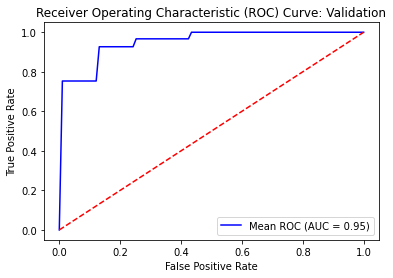

Mean Confusion Matrix:
[[6.4 1.4]
 [0.8 5. ]]
Cross-validation Accuracy Scores: [0.85714286 0.85714286 0.92857143 0.76923077 0.76923077]
Mean Accuracy: 0.8362637362637363
Cross-validation f1 Scores: [0.83333333 0.85714286 0.90909091 0.76923077 0.72727273]
Mean f1: 0.8192141192141191


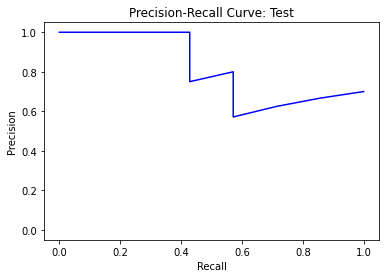

Accuracy Test: 0.6470588235294118
F1 Test: 0.5714285714285714
[[7 3]
 [3 4]]


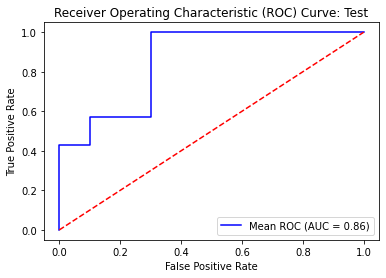

Feature Importance:
task_Scan: -0.917716954872148
fixation_ratio: -0.2535359476999304
task_Read: 0.11232395736416301
Med_sp: -0.007329640080421029
fixation_number: -0.006574286444561039
fixation_length: 0.003963784636795253
Low_sp: -0.0035275911561711837
High_sp: -0.0020228143452314384


In [15]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score, precision_recall_curve
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

X = df_fix[['task', 'fixation_number', 'fixation_length', 'fixation_ratio', 'Low_sp', 'Med_sp', 'High_sp']]
y = df_fix['group']

# Encode the target variable into binary format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode categorical features
X_encoded = pd.get_dummies(X)

# Split into train/validation and test sets

X_train_val, X_test_main, y_train_val, y_test_main = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Initialize SVM classifier
svm_model = SVC(kernel='linear')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
smote = SMOTE(random_state=42)

# Lists to store results for each fold
conf_matrices = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
cv_scores_acc = []
cv_scores_f1 = []
best_model = None
best_f1 = 0

for train_index, test_index in cv.split(X_train_val, y_train_val):
    X_train, X_test = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
    y_train, y_test = y_train_val[train_index], y_train_val[test_index]

    # Apply SMOTE to balance the training set for each fold
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Fit the model on the balanced training set
    svm_model.fit(X_resampled, y_resampled)

    # Predict on the test set and calculate scores
    y_pred = svm_model.decision_function(X_test)
    fold_accuracy = accuracy_score(y_test, y_pred > 0)
    cv_scores_acc.append(fold_accuracy)
    fold_f1 = f1_score(y_test, y_pred > 0)
    cv_scores_f1.append(fold_f1)
    
    # Check if the metric is best for the current model and save it
    if fold_f1 > best_f1:
        best_f1 = fold_f1
        best_model = deepcopy(svm_model)

    # Calculate confusion matrix for this fold
    conf_matrix = confusion_matrix(y_test, y_pred > 0)
    conf_matrices.append(conf_matrix)

    # Calculate ROC curve and AUC for this fold
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

# Aggregate results across folds
mean_conf_matrix = np.mean(conf_matrices, axis=0)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

# Plot ROC curve
plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve: Validation')
plt.legend(loc='lower right')
plt.show()

print("Mean Confusion Matrix:")
print(mean_conf_matrix)

cv_scores_acc = np.array(cv_scores_acc)
cv_scores_f1 = np.array(cv_scores_f1)

print("Cross-validation Accuracy Scores:", cv_scores_acc)
print("Mean Accuracy:", cv_scores_acc.mean())

print("Cross-validation f1 Scores:", cv_scores_f1)
print("Mean f1:", cv_scores_f1.mean())

# Predict for test set
y_pred = best_model.decision_function(X_test_main)
test_accuracy = accuracy_score(y_test_main, y_pred > 0)
test_f1 = f1_score(y_test_main, y_pred > 0)

conf_matrix = confusion_matrix(y_test_main, y_pred > 0)
fpr, tpr, _ = roc_curve(y_test_main, y_pred)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test_main, y_pred)

# Plot Precision-Recall curve for test
plt.figure()
plt.plot(recall, precision, color='b')
plt.plot([0, 0], [0, 0], color='r', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Test')
# plt.legend(loc='lower right')
plt.show()


print("Accuracy Test:", test_accuracy)
print("F1 Test:", test_f1)
print(conf_matrix)

# Plot ROC curve for test
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'Mean ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve: Test')
plt.legend(loc='lower right')
plt.show()

feature_importance = best_model.coef_[0]

# Map feature names to coefficients
feature_importance_dict = dict(zip(X_train_val.columns, feature_importance))

# Sort features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)

print("Feature Importance:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

# OFSCA

"Could you try to estimate the OFSCA angles assuming two scaling ranges?
It would be good to assume two patterns of scaling ranges: eg. about 1 to 1.5 and about 2 to 2.5.
Then, please check whether the estimated angles are approximately the same or different in these two scaling ranges.
"

In [109]:
def save_ofsca(df, session_id, x_name, y_name, folder_to_save, start_range, end_range):
    x = df.loc[df['Session_id'] == session_id, x_name].tolist()[0]
    y = df.loc[df['Session_id'] == session_id, y_name].tolist()[0]
    group = df.loc[df['Session_id'] == session_id, "Session_desc"].tolist()[0]
    fig = ofsca_1(x, y, start_range, end_range)
    folder_path = f"../../../plots/{folder_to_save}/{group}"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    file_name = f"{session_id}.png"
    file_path = os.path.join(folder_path, file_name)

    plt.savefig(file_path)

def ofsca_1(x, y, start_range, end_range):
    ofsca_obj = ofsca.OFSCA(x_vector=np.array(x),
                        y_vector=np.array(y),
                        order=2,
                        start_scale=start_range, # changed these 2 parameters, not sure if this is correct
                        end_scale=end_range,
                        make_integration=True,
                        n_angles=64)
    ofsca_obj.perform_OFSCA()
    fig = ofsca_obj.get_ofsca_fig(rcParams={'font.size': 14}, alpha_graphs_ylim=[0.4, 2.8])
    theta_hats_1.append(ofsca_obj.comp1.theta_hat)
    thetas_1.append(ofsca_obj.comp1.theta)
    
    theta_hats_2.append(ofsca_obj.comp2.theta_hat)
    thetas_2.append(ofsca_obj.comp2.theta)
    return fig


# session_id_1 = '0vDqTTS4iDY6DF5NOp8f'
# x = df.loc[df['Session_id'] == session_id_1, 'Filtered_BPOGX'].tolist()[0]
# y = df.loc[df['Session_id'] == session_id_1, 'Filtered_BPOGY'].tolist()[0]

sessions = df["Session_id"].unique()
processed = []
thetas_1 = []
theta_hats_1 = []
thetas_2 = []
theta_hats_2 = []

# ofsca_1(x, y, 1, 1.5)
# save_ofsca(session_id_1, 'X_HEAD', 'Y_HEAD', 'OFSCA_head_movements')

In [117]:
for i, s in enumerate(sessions):
    if i not in processed:
        try:
            save_ofsca(df, s, 'Filtered_BPOGX', 'Filtered_BPOGY', 'OFSCA_eye_2_2.5', 2, 2.5)
            processed.append(i)
            print("Processed:", len(processed))
        except ValueError:
            print(f"{s} not processed")

nOQRQnXCjYfEjdHkGsVt not processed


In [107]:
thetas_1_15 = thetas_1
theta_hats_1_15 = theta_hats_1
thetas_2_15 = thetas_2
theta_hats_2_15 = theta_hats_2

In [108]:
len(thetas_1_15)

84

In [118]:
thetas_1_25 = thetas_1
theta_hats_1_25 = theta_hats_1
thetas_2_25 = thetas_2
theta_hats_2_25 = theta_hats_2

1st Component Thetas 3282.5 0.21845166926618664
2nd Component Thetas 3364.5 0.3024634116601853


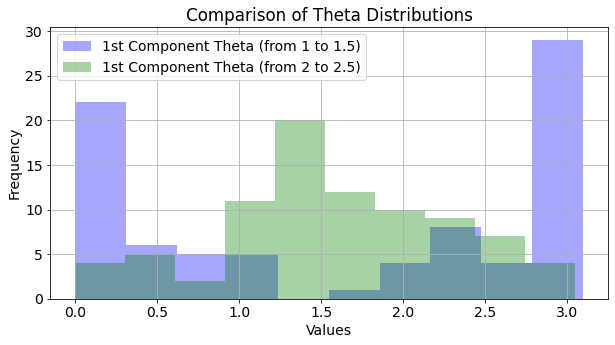

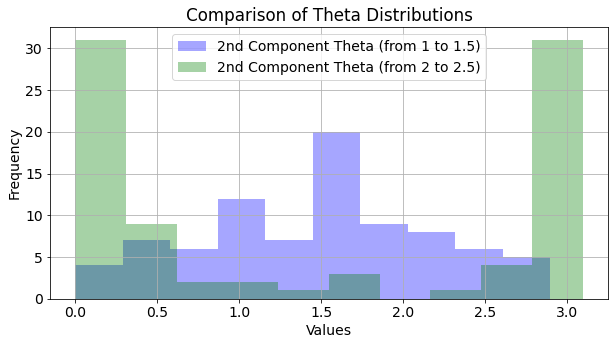

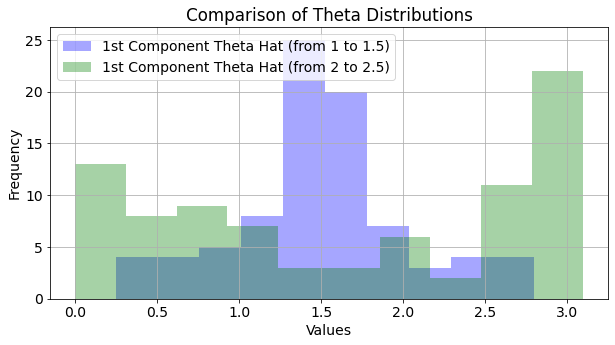

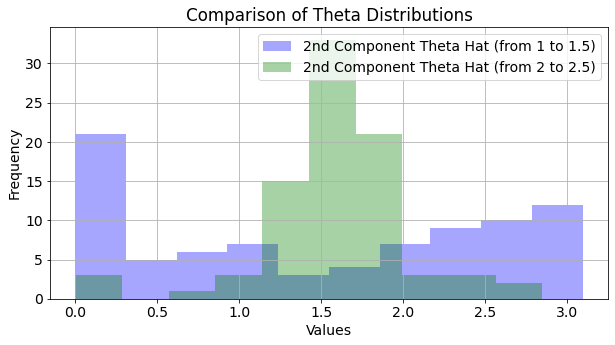

In [119]:
def plot_hist(ang_1, ang_2, label1, label2, file_name):
    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.hist(ang_1, bins=10, alpha=0.35, color='blue', label=label1)
    plt.hist(ang_2, bins=10, alpha=0.35, color='green', label=label2)

    # Add labels and title
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Comparison of Theta Distributions')
    plt.legend()

    # Show plot
    plt.grid(True)
    folder_path = f"../../../plots/OFSCA_diagrams"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    file_path = os.path.join(folder_path, file_name)
    plt.savefig(file_path)
    
plot_hist(thetas_1_15, thetas_1_25, '1st Component Theta (from 1 to 1.5)', '1st Component Theta (from 2 to 2.5)', '1_comp_theta')
plot_hist(thetas_2_15, thetas_2_25, '2nd Component Theta (from 1 to 1.5)', '2nd Component Theta (from 2 to 2.5)', '2_comp_theta')
plot_hist(theta_hats_1_15, theta_hats_1_25, '1st Component Theta Hat (from 1 to 1.5)', '1st Component Theta Hat (from 2 to 2.5)', '1_comp_theta_hat')
plot_hist(theta_hats_2_15, theta_hats_2_25, '2nd Component Theta Hat (from 1 to 1.5)', '2nd Component Theta Hat (from 2 to 2.5)', '2_comp_theta_hat')

U1, p = mannwhitneyu(thetas_1_15, thetas_1_25)
print('1st Component Thetas', U1, p)
U1, p = mannwhitneyu(thetas_2_15, thetas_2_25)
print('2nd Component Thetas', U1, p)

In [11]:
df_ex = pd.DataFrame({"X": x, "Y": y})
df_ex

NameError: name 'x' is not defined

In [ ]:
df_ex.to_csv("sample1.csv", index=False)